# **Laporan Proyek Machine Learning - Kevin Aditya Ikhsan**

## **1. Project Overview**


Olist, the largest department store in Brazilian marketplaces, bridges the gap between small businesses and a wide array of sales channels through a seamless and centralized platform. Merchants on Olist can sell their products easily while leveraging Olist's logistics network for efficient delivery. To enhance customer satisfaction and streamline their experience, Olist collects feedback through post-purchase surveys, providing valuable insights into the shopping experience[[1]](https://doi.org/10.3390/su152316151). These customer interactions present an opportunity to develop personalized recommendations, driving both customer engagement and seller success [[2]](https://doi.org/10.3390/su131910786).

The project focuses on building a recommendation system using content-based filtering and collaborative filtering approaches. A robust recommendation system is essential to enhance the shopping experience, increase customer retention, and support Olist’s mission of empowering small businesses. Leveraging the collected data, the project aims to deliver accurate and personalized recommendations, drawing insights from customer feedback and product attributes to improve user satisfaction and overall marketplace performance.

## **2. Business Understanding**


### **2.1. Problem Statements**

Olist aims to enhance customer satisfaction and drive sales by offering personalized product recommendations. However, the current system lacks a robust mechanism to analyze customer feedback and product attributes for tailored suggestions, potentially leading to missed opportunities for customer retention and merchant success.  

### **2.2. Goals**

The primary goal is to develop a recommendation system that delivers accurate and personalized product suggestions to customers, enhancing their shopping experience while increasing sales for merchants.  

### **2.3. Solution statements**

1. **Content-Based Filtering**: Analyze product attributes and customer preferences to suggest items similar to those they have purchased.
2. **Collaborative Filtering**: Leveraging patterns in customer interactions and purchase history, recommend products based on the behavior and preferences of similar users.  

## **3. Data Understanding**

### **3.1. Import Libraries**

In [1]:
!pip install rapidfuzz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.5 MB/s eta 0:00:00


In [2]:
# Data manipulation.
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

# Data cleaning
import unicodedata
from itertools import combinations, permutations
from rapidfuzz.fuzz import ratio

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

# Hide warning.
import warnings
warnings.filterwarnings('ignore')


### **3.2. Load Datasets**

The dataset used for the project is the [**Brazilian E-Commerce Public Dataset by Olist** [3]](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce). It contains approximately 100,000 orders made at Olist Store between 2016 and 2018. The dataset is anonymized and ideal for developing a recommendation system as it provides valuable insights into customer preferences, product details, and purchasing behavior.

**Tables Used for the Recommendation System**  
1. **Customers**: Contains customer IDs and unique customer identifiers, which are critical for understanding individual purchasing behavior and linking reviews and orders.  
2. **Orders**: Provides order information, including order IDs and customer IDs, which helps in tracking purchasing patterns.  
3. **Order Items**: Includes details about the products purchased in each order, such as product IDs and price, essential for mapping product preferences.  
4. **Order Reviews**: Captures customer feedback in the form of review scores, crucial for building collaborative filtering models by identifying user satisfaction and preferences.  
5. **Products**: Contains product-level information, including product IDs, names, and physical attributes, which can be used for content-based filtering.  
6. **Product Category**: Maps product categories name to English.

The relationships between these tables are illustrated in the dataset's schema. For example, Order Items links orders to specific products, while Customers connects unique buyers to their respective orders and reviews. Understanding dataset structure is essential for designing a recommendation system that effectively integrates both content-based filtering and collaborative filtering techniques.

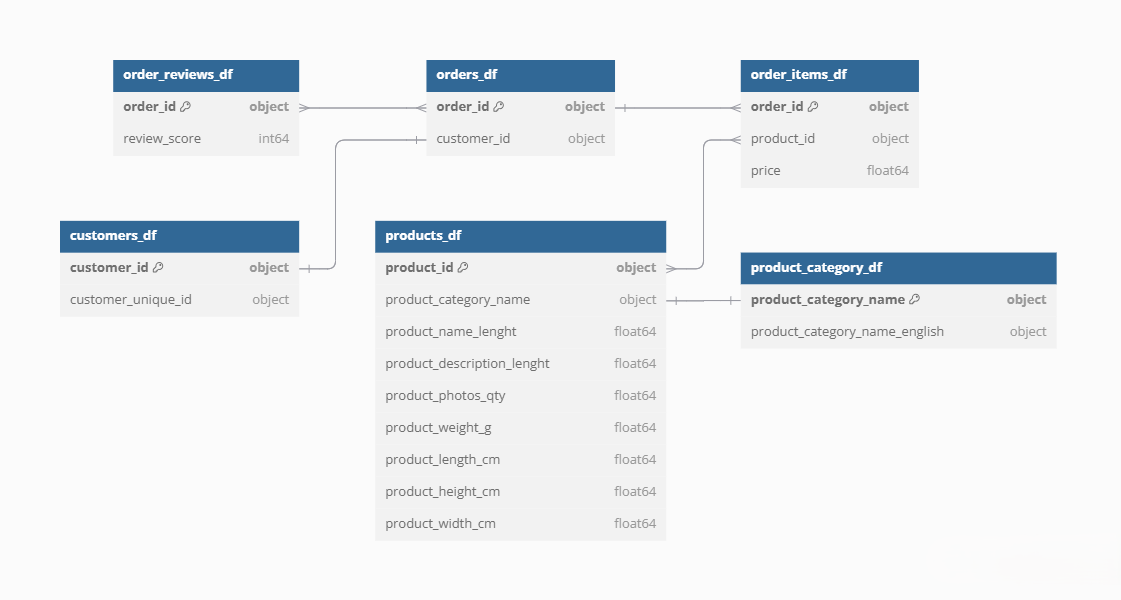

In [3]:
# Download the "Brazilian E-commerce" dataset from Kaggle.
!kaggle datasets download -d olistbr/brazilian-ecommerce

# Extract the contents of the "brazilian-ecommerce.zip" file.
!unzip brazilian-ecommerce.zip

# Remove the "brazilian-ecommerce.zip" file.
!rm brazilian-ecommerce.zip


Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
100% 42.6M/42.6M [00:00<00:00, 232MB/s]
100% 42.6M/42.6M [00:00<00:00, 219MB/s]
Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [4]:
def analyze_dataframe(df):
    """
    Analyzes a DataFrame and provides a summary of its columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - None. Displays the first few rows of the DataFrame and a summary table.
    """

    # Initialize a dictionary to store summary statistics for each column.
    summary_data = {
        'Column': df.columns.values,
        'Type': df.dtypes.values,
        'Null': df.isna().sum().values,
        'Unique': df.nunique().values,
        'Unique Values': [df[i].unique() for i in df.columns],
        'Min': pd.Series(dtype='object'),
        'Q1': pd.Series(dtype='object'),
        'Median': pd.Series(dtype='object'),
        'Q3': pd.Series(dtype='object'),
        'Max': pd.Series(dtype='object')
    }

    # Create a DataFrame from the summary data.
    summary = pd.DataFrame(summary_data, index=range(len(df.columns)))

    # Identify numeric columns.
    numeric_cols = df.select_dtypes(include='number').columns

    # Calculate and populate min/max values for numeric columns.
    for col in numeric_cols:
        summary.loc[summary['Column'] == col, 'Min'] = df[col].min()
        summary.loc[summary['Column'] == col, 'Q1'] = df[col].quantile(0.25)
        summary.loc[summary['Column'] == col, 'Median'] = df[col].median()
        summary.loc[summary['Column'] == col, 'Q3'] = df[col].quantile(0.75)
        summary.loc[summary['Column'] == col, 'Max'] = df[col].max()

    # Display the first few rows of the DataFrame and the summary table.
    display(
        df[:1],
        df.shape,
        summary
    )


#### **3.2.1. Customers**

| Columns | Description |
| --- | --- |
| **customer_id** | Unique identifier for each customer. |
| **customer_unique_id** | Unique identifier for each customer (anonymized). |
| **customer_zip_code_prefix** | Zip code prefix of the customer's address. |
| **customer_city** | City where the customer is located. |
| **customer_state** | State where the customer is located. |

In [5]:
customers_df = pd.read_csv('olist_customers_dataset.csv')
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
customers_df = customers_df[['customer_id', 'customer_unique_id']]
analyze_dataframe(customers_df)

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0


(99441, 2)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,customer_id,object,0,99441,"[06b8999e2fba1a1fbc88172c00ba8bc7, 18955e83d33...",NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,0,96096,"[861eff4711a542e4b93843c6dd7febb0, 290c77bc529...",NaN,NaN,NaN,NaN,NaN


**Customers Table Information**
- The `customers_df` table consists of **99,441 records** and provides customer-level information.  
- It includes two features:  
  1. **`customer_id`**: A unique identifier for each customer’s order, used to link with the `orders_df` table. There are **99,441 unique values.**
  2. **`customer_unique_id`**: A unique identifier for each customer across all orders. With **96,096 unique values**, indicates that some customers placed multiple orders.  
- The table contains **no missing values.**

**Relationship in the Schema**
- The `customer_id` field connects the `customers_df` table to the `orders_df` table, enabling the tracking of customer behavior and linking orders to specific customers.  

#### **3.2.2. Order Items**

| Columns | Description |
| --- | --- |
| **order_id** | Unique identifier for the order. |
| **order_item_id** | Unique identifier for each item within an order. |
| **product_id** | Unique identifier for the product being ordered. |
| **seller_id** | Unique identifier for the seller who listed the product. |
| **shipping_limit_date** | Date and time when the seller has to ship the product. |
| **price** | Price of the product. |
| **freight_value** | Shipping fee for the product. |

In [7]:
order_items_df = pd.read_csv('olist_order_items_dataset.csv')
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
order_items_df = order_items_df[['order_id', 'product_id', 'price']]
analyze_dataframe(order_items_df)

,order_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9


(112650, 3)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,order_id,object,0,98666,"[00010242fe8c5a6d1ba2dd792cb16214, 00018f77f2f...",NaN,NaN,NaN,NaN,NaN
1,product_id,object,0,32951,"[4244733e06e7ecb4970a6e2683c13e61, e5f2d52b802...",NaN,NaN,NaN,NaN,NaN
2,price,float64,0,5968,"[58.9, 239.9, 199.0, 12.99, 199.9, 21.9, 19.9,...",0.85,39.9,74.99,134.9,6735.0


**Orders Table Information**
- The `order_items_df` table consists of **112,650 records** and provides item-level details for customer orders.  
- It includes three features:  
  1. **`order_id`**: A unique identifier for each order, used to link with the `orders_df` table. There are **98,666 unique values**, indicating that some orders contain multiple items.  
  2. **`product_id`**: A unique identifier for each product, used to link with the `products_df` table. There are **32,951 unique products** purchased across all orders.  
  3. **`price`**: The price of the purchased item in Brazilian Real. Prices range from **0.85** to **6,735.00**, with a median price of **74.99**.  
- The table contains **no missing values.**

**Relationship in the Schema**
- The `order_id` column connects the `order_items_df` table to the `orders_df` table, enabling the identification of items within each order.  
- The `product_id` column links the `order_items_df` table to the `products_df` table, allowing access to product attributes and categories for each item in an order.

#### **3.2.3. Order Reviews**

|Columns|Description|
|---|---|
|**review_id**|Unique identifier for each review.|
|**order_id**|Unique identifier for the order that the review is associated with.|
|**review_score**|Numerical score (1-5) given by the customer for the product.|
|**review_comment_title**|Title of the review comment.|
|**review_comment_message**|Text of the review comment.|
|**review_creation_date**|Date and time when the review was created.|
|**review_answer_timestamp**|Date and time when the seller responded to the review (if applicable).|

In [9]:
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [10]:
order_reviews_df = order_reviews_df[['order_id', 'review_score']]
analyze_dataframe(order_reviews_df)

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4


(99224, 2)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,order_id,object,0,98673,"[73fc7af87114b39712e6da79b0a377eb, a548910a1c6...",NaN,NaN,NaN,NaN,NaN
1,review_score,int64,0,5,"[4, 5, 1, 3, 2]",1,4.0,5.0,5.0,5


**Order Reviews Table Information**
- The `order_reviews_df` table consists of **99,224 records** and provides customer feedback on orders.  
- It includes two features:  
  1. **`order_id`**: A unique identifier for each order, used to link with the `orders_df` table. There are **98,673 unique values**, indicating that most orders have corresponding reviews.  
  2. **`review_score`**: A numerical score given by customers, ranging from **1** (lowest satisfaction) to **5** (highest satisfaction). The median and upper quartile scores are **5**, showing a tendency toward positive feedback.  
- No missing values exist in the table, ensuring that all reviews are complete.  
- The distribution of review scores suggests an overall positive sentiment among customers.  

**Relationship in the Schema**  
- The `order_id` column connects the `order_reviews_df` table to the `orders_df` table, linking reviews to their corresponding orders. The relationship is crucial for analyzing customer satisfaction in relation to specific orders.

#### **3.2.4. Orders**

| Columns | Description |
| --- | --- |
| **order_id** | Unique identifier for each order. |
| **customer_id** | Unique identifier for the customer who placed the order. |
| **order_status** | Current status of the order (e.g., delivered, shipped, canceled). |
| **order_purchase_timestamp** | Date and time when the order was placed. |
| **order_approved_at** | Date and time when the payment for the order was approved. |
| **order_delivered_carrier_date** | Date and time when the order was handed over to the carrier. |
| **order_delivered_customer_date** | Date and time when the order was delivered to the customer. |
| **order_estimated_delivery_date** | Estimated date when the order is expected to be delivered. |

In [11]:
orders_df = pd.read_csv('olist_orders_dataset.csv')
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [12]:
orders_df = orders_df[['order_id', 'customer_id']]
analyze_dataframe(orders_df)

,order_id,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d


(99441, 2)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,order_id,object,0,99441,"[e481f51cbdc54678b7cc49136f2d6af7, 53cdb2fc8bc...",NaN,NaN,NaN,NaN,NaN
1,customer_id,object,0,99441,"[9ef432eb6251297304e76186b10a928d, b0830fb4747...",NaN,NaN,NaN,NaN,NaN


**Orders Table Information**
- The `orders_df` table consists of **99,441 records** and provides information about customer orders.  
- It includes two features:  
  1. **`order_id`**: A unique identifier for each order. There are **99,441 unique values**, indicating that each order is distinct.  
  2. **`customer_id`**: A unique identifier for each customer associated with an order, used to link with the `customers_df` table. There are **99,441 unique values**, ensuring that every order has a corresponding customer.  
- The table contains **no missing values**, making it reliable for linking orders to customers and other related data.  

**Relationship in the Schema**  
- The `order_id` column connects the `orders_df` table to the `order_items_df` and `order_reviews_df` tables, enabling the linkage of orders to specific items and customer reviews.  
- The `customer_id` column connects the `orders_df` table to the `customers_df` table, linking each order to the customer who placed it.  

#### **3.2.5. Products**

| Columns | Description |
| --- | --- |
| **product_id** | Unique identifier for each product. |
| **product_category_name** | Name of the category that the product belongs to. |
| **product_name_lenght** | Number of characters in the product name. |
| **product_description_lenght** | Number of characters in the product description. |
| **product_photos_qty** | Number of photos for the product. |
| **product_weight_g** | Weight of the product in grams. |
| **product_length_cm** | Length of the product in centimeters. |
| **product_height_cm** | Height of the product in centimeters. |
| **product_width_cm** | Width of the product in centimeters. |

In [13]:
products_df = pd.read_csv('olist_products_dataset.csv')
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [14]:
analyze_dataframe(products_df)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0


(32951, 9)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,product_id,object,0,32951,"[1e9e8ef04dbcff4541ed26657ea517e5, 3aa071139cb...",NaN,NaN,NaN,NaN,NaN
1,product_category_name,object,610,73,"[perfumaria, artes, esporte_lazer, bebes, util...",NaN,NaN,NaN,NaN,NaN
2,product_name_lenght,float64,610,66,"[40.0, 44.0, 46.0, 27.0, 37.0, 60.0, 56.0, 57....",5.0,42.0,51.0,57.0,76.0
3,product_description_lenght,float64,610,2960,"[287.0, 276.0, 250.0, 261.0, 402.0, 745.0, 127...",4.0,339.0,595.0,972.0,3992.0
4,product_photos_qty,float64,610,19,"[1.0, 4.0, 2.0, 3.0, 5.0, 9.0, 6.0, nan, 7.0, ...",1.0,1.0,1.0,3.0,20.0
5,product_weight_g,float64,2,2204,"[225.0, 1000.0, 154.0, 371.0, 625.0, 200.0, 18...",0.0,300.0,700.0,1900.0,40425.0
6,product_length_cm,float64,2,99,"[16.0, 30.0, 18.0, 26.0, 20.0, 38.0, 70.0, 40....",7.0,18.0,25.0,38.0,105.0
7,product_height_cm,float64,2,102,"[10.0, 18.0, 9.0, 4.0, 17.0, 5.0, 24.0, 8.0, 1...",2.0,8.0,13.0,21.0,105.0
8,product_width_cm,float64,2,95,"[14.0, 20.0, 15.0, 26.0, 13.0, 11.0, 44.0, 40....",6.0,15.0,20.0,30.0,118.0


**Products Table Information**
- The `products_df` table consists of **32,951 records** and provides detailed information about products available in the Olist marketplace.  

- **Features**:  
  1. **`product_id`**: A unique identifier for each product. There are **32,951 unique values**, ensuring that each product is distinct.  
  2. **`product_category_name`**: The category of the product. It contains **73 unique categories**, with **610 missing values** that can potentially be handled for analysis.  
  3. **`product_name_lenght`**: The character length of product names, ranging from **5** to **76**, with a median of **51**.  
  4. **`product_description_lenght`**: The character length of product descriptions, ranging from **4** to **3,992**, with a median of **595**.  
  5. **`product_photos_qty`**: The number of photos associated with each product. Values range from **1** to **20**, with a median of **1**, indicating many products have only one photo.  
  6. **`product_weight_g`**: The weight of the product in grams, ranging from **0** to **40,425**, with a median of **700g**.  
  7. **`product_length_cm`**: The product's length in centimeters, ranging from **7** to **105**, with a median of **25cm**.  
  8. **`product_height_cm`**: The product's height in centimeters, ranging from **2** to **105**, with a median of **13cm**.  
  9. **`product_width_cm`**: The product's width in centimeters, ranging from **6** to **118**, with a median of **20cm**.  

- The `product_category_name` column has **610 missing values**, which may require imputation or exclusion depending on the analysis.  
- Product attributes such as weight and dimensions show significant variability, which can be useful for personalized recommendations.  

- **Relationship in the Schema**:  
  - The `product_id` column connects the `products_df` table to the `order_items_df` table, allowing products to be linked to specific orders.  
  - The `product_category_name` can be further detailed by linking to the `product_category_df` table, which provides English names for categories.

#### **3.2.6. Product Category**

In [15]:
product_category_df = pd.read_csv('product_category_name_translation.csv')
product_category_df.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [16]:
analyze_dataframe(product_category_df)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


(71, 2)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,product_category_name,object,0,71,"[beleza_saude, informatica_acessorios, automot...",NaN,NaN,NaN,NaN,NaN
1,product_category_name_english,object,0,71,"[health_beauty, computers_accessories, auto, b...",NaN,NaN,NaN,NaN,NaN


**Product Category Table Information**
- The `product_category_df` table consists of **71 records** and provides a mapping between product category names in Portuguese and their corresponding English translations.  

- **Features**:  
  1. **`product_category_name`**: The product category in Portuguese, with **71 unique values**, representing different types of products available in the dataset.  
  2. **`product_category_name_english`**: The English translation of the product category, also with **71 unique values**, ensuring one-to-one correspondence with the Portuguese category names.  

- The table contains **no missing values**, ensuring complete mapping between Portuguese and English product categories.  
- The table is essential for interpreting product categories in a more universally understandable format, particularly when analyzing data or presenting results to a non-Portuguese-speaking audience.  

- **Relationship in the Schema**:  
  - The `product_category_name` column connects the `product_category_df` table to the `products_df` table, enabling the categorization of products into their respective English-named categories.

### **3.3. Exploratory Data Analysis**

#### **3.3.1. Products Price**

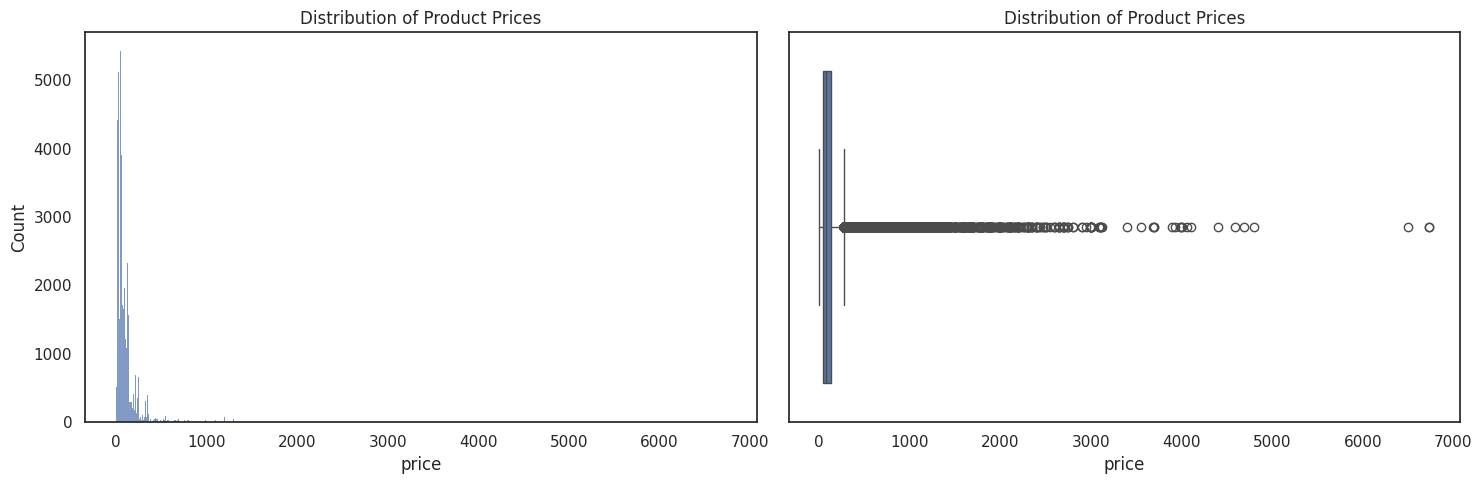

In [17]:
# Create a figure with two subplots.
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for the price distribution.
sns.histplot(order_items_df['price'], ax=axes[0])
axes[0].set_title('Distribution of Product Prices')

# Plot boxplot for the price distribution.
sns.boxplot(x=order_items_df['price'], ax=axes[1])
axes[1].set_title('Distribution of Product Prices')

# Adjust layout to prevent overlap.
plt.tight_layout()
plt.show()


The analysis of product prices reveals a highly skewed distribution, as shown in the histogram. The majority of product prices are concentrated below **500 BRL**, with only a small number of items priced above **1,000 BRL**. It's suggests that most products are relatively affordable, catering to a broader customer base. The boxplot further highlights the presence of significant outliers, with prices extending up to **6,735 BRL**, representing luxury or specialty items. The interquartile range (IQR) indicates that most product prices fall between approximately **39.9 BRL** and **134.9 BRL**. These insights suggest that while the marketplace primarily targets affordability, the inclusion of high-value products adds diversity to the catalog. These outliers may require careful consideration during the development of the recommendation system to ensure they do not overly influence results.

#### **3.3.2. Review Score**

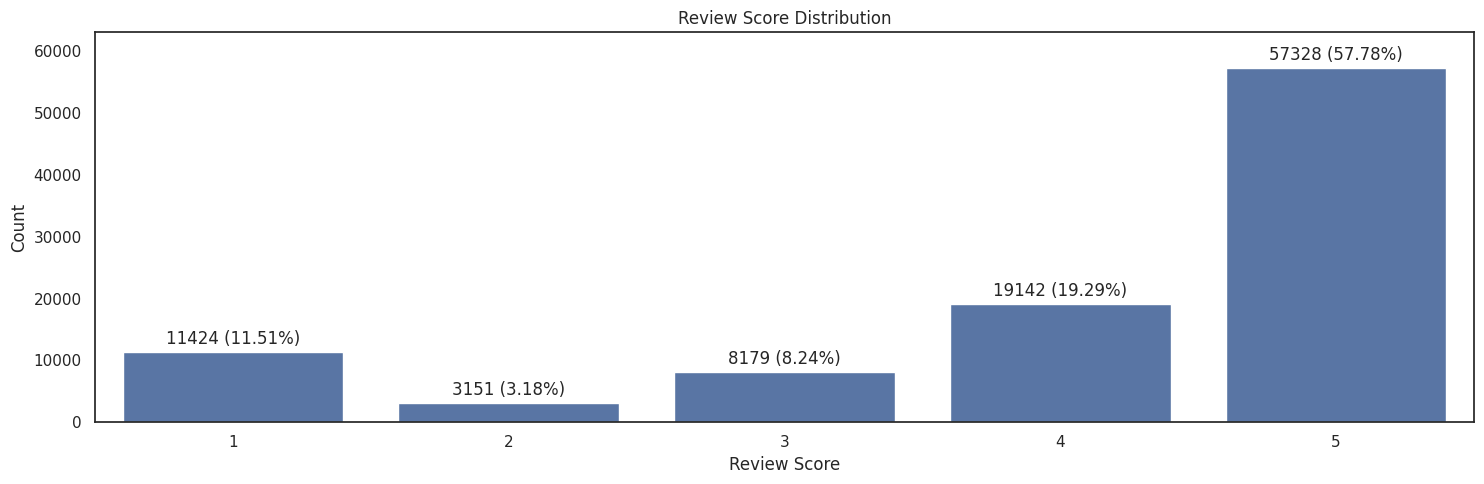

In [18]:
# Group review scores and calculate count and percentage.
review_scores = order_reviews_df.groupby('review_score').agg(
    count=('review_score', 'count'),
    percentage=(
        'review_score',
        lambda x: round(100 * x.count() / len(order_reviews_df), 2)
    )
)

# Create a bar plot for the review score distribution.
plt.figure(figsize=(15, 5))
sns.barplot(x=review_scores.index, y=review_scores['count'])
plt.title('Review Scores Distribution')
plt.xlabel('Review Scores')
plt.ylabel('Count')

# Annotate bar plot with count and percentage values.
for i, v in enumerate(review_scores['count']):
    plt.text(i, v + max(review_scores['count']) * 0.01,
             f'{v} ({review_scores.iloc[i]["percentage"]:.2f}%)',
             ha='center', va='bottom')

# Adjust y-axis limits for better visualization.
plt.ylim(0, max(review_scores['count']) * 1.1)
plt.tight_layout()
plt.show()


The distribution of review scores provides insights into customer satisfaction levels. The bar chart shows that the majority of reviews, accounting for **57.78% (57,328 reviews)**, have a perfect score of 5, indicating highly satisfied customers. It's is followed by a score of 4, with **19.29% (19,142 reviews)**, also reflecting positive feedback. On the lower end, **11.51% (11,424 reviews)** of reviews have a score of 1, representing dissatisfied customers, while scores of 2 and 3 account for **3.18% (3,151 reviews)** and **8.24% (8,179 reviews)**, respectively.

Review scores distribution demonstrates that the platform generally maintains a high level of customer satisfaction, as more than **77% of reviews** are positive (scores of 4 and 5). However, the presence of a notable proportion of low ratings (1 and 2) suggests areas for improvement in the customer experience, which can be targeted in recommendation strategies.

#### **3.3.3. Products Category**

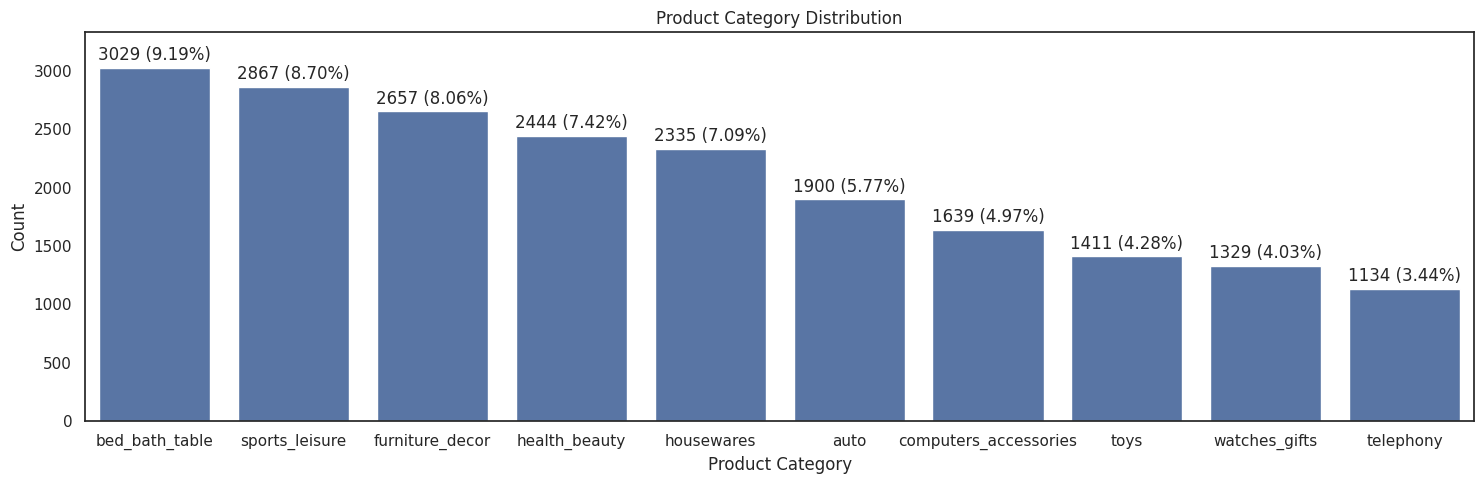

In [19]:
# Merge product and category data, and calculate count and percentage.
temp_df = pd.merge(
    products_df,
    product_category_df,
    on='product_category_name',
    how='left'
)
temp_df = temp_df.groupby('product_category_name_english').agg(
    count=('product_category_name_english', 'count'),
    percentage=(
        'product_category_name_english',
        lambda x: round(100 * x.count() / len(temp_df), 2)
    )
)
temp_df = temp_df.sort_values(by='count', ascending=False)[:10]

# Create a bar plot for the top 10 product categories.
plt.figure(figsize=(15, 5))
sns.barplot(x=temp_df.index, y=temp_df['count'])
plt.title('Product Category Distribution')
plt.xlabel('Product Category')
plt.ylabel('Count')

# Annotate bar plot with count and percentage values.
for i, v in enumerate(temp_df['count']):
    plt.text(
        i,
        v + max(temp_df['count']) * 0.01,
        f'{v} ({temp_df.iloc[i]["percentage"]:.2f}%)',
        ha='center',
        va='bottom'
    )

# Adjust y-axis and layout for better visualization.
plt.ylim(0, max(temp_df['count']) * 1.1)
plt.tight_layout()
plt.show()


The analysis of product category distribution highlights the top 10 most popular categories in the dataset. The **bed, bath, and table** category leads with **3,029 products (9.19%)**, followed by **sports leisure** at **2,867 products (8.70%)**, and **furniture decor** with **2,657 products (8.06%)**. Other notable categories include **health beauty (7.42%)**, **housewares (7.09%)**, and **auto (5.77%)**. The categories **computers accessories**, **toys**, **watches gifts**, and **telephony** each make up between **3.44% and 4.97%** of the total products.

The distribution shows that the marketplace offers a wide range of categories, with household and lifestyle-related items dominating the catalog. These insights are crucial for developing the recommendation system, as they help in identifying key product categories that contribute significantly to customer engagement. Tailoring recommendations based on these popular categories could enhance customer satisfaction and increase sales.

In [20]:
def find_potential_typos(column):
    """
    Identifies potential typos in a column where similarity is > 90.

    Parameters:
    - column (pd.Series): The column to analyze for typos.

    Returns:
    - pd.DataFrame: A DataFrame with potential typos, showing pairs and
        similarity scores.
    - str: A message indicating whether typos were found.
    """

    # Get unique values from the column.
    unique_values = column.unique()

    # Initialize a list to store potential typos.
    potential_typos = []

    # Compare each pair of unique values using combinations.
    for val1, val2 in combinations(unique_values, 2):
        # Calculate similarity ratio
        similarity = ratio(val1, val2)
        # Check if similarity falls within the specified thresholds.
        if 90 < similarity < 100:
            potential_typos.append({
                'Value': val1,
                'Potential_Match': val2,
                'Similarity': round(similarity, 2)
            })

    # Convert the results into a DataFrame.
    typos_df = pd.DataFrame(potential_typos)

    # Check if the DataFrame is empty.
    if typos_df.empty:
        print(f"No typos found in {column.name}.")
    else:
        print(f"Found {len(typos_df)} potential typos in {column.name}:")

    return typos_df.head() if len(typos_df) >= 5 else typos_df


In [21]:
find_potential_typos(products_df['product_category_name'])

Found 2 potential typos in product_category_name:


,Value,Potential_Match,Similarity
0,eletrodomesticos,eletrodomesticos_2,94.12
1,casa_conforto,casa_conforto_2,92.86


The analysis of the `product_category_name` column identified 2 potential typos: "eletrodomesticos" and "eletrodomesticos_2" (94.12% similarity) and "casa_conforto" and "casa_conforto_2" (92.86% similarity). These findings suggest minor inconsistencies in category naming that may require standardization to ensure data quality and consistency in analysis.

In [22]:
# Define categories with typos.
typos_cat = [
    'eletrodomesticos',
    'eletrodomesticos_2',
    'casa_conforto',
    'casa_conforto_2'
]

# Count occurrences of products in typo categories.
products_df[
    products_df['product_category_name'].isin(typos_cat)
].value_counts('product_category_name')


,count
product_category_name,
eletrodomesticos,370
casa_conforto,111
eletrodomesticos_2,90
casa_conforto_2,5


The `product_category_name` column contains inconsistencies across four categories identified as potential typos. Specifically, "eletrodomesticos" appears 370 times, while its variant "eletrodomesticos_2" appears 90 times. Similarly, "casa_conforto" appears 111 times, and its variant "casa_conforto_2" appears only 5 times. These discrepancies suggest that the categories need to be standardized by merging the variants into their respective main categories to ensure consistency and improve data quality.

In [23]:
find_potential_typos(product_category_df['product_category_name'])

Found 2 potential typos in product_category_name:


,Value,Potential_Match,Similarity
0,eletrodomesticos,eletrodomesticos_2,94.12
1,casa_conforto,casa_conforto_2,92.86


The analysis of the `product_category_name` column in `product_category_df` identified 2 potential typos: "eletrodomesticos" and "eletrodomesticos_2" (94.12% similarity) as well as "casa_conforto" and "casa_conforto_2" (92.86% similarity). These discrepancies suggest minor inconsistencies in category naming that may require standardization to ensure data accuracy and consistency in both the Portuguese and English translations.

In [24]:
find_potential_typos(product_category_df['product_category_name_english'])

Found 2 potential typos in product_category_name_english:


,Value,Potential_Match,Similarity
0,fashion_male_clothing,fashio_female_clothing,93.02
1,home_appliances,home_appliances_2,93.75


The analysis of the `product_category_name_english` column in `product_category_df` identified 2 potential typos. First, "fashio_female_clothing" should be corrected to "fashion_female_clothing" to maintain consistent naming, while "fashion_male_clothing" is a valid and distinct category that requires no correction. Second, "home_appliances_2" should be standardized to "home_appliances" to ensure uniformity within the `product_category_name_english` column. These adjustments will improve data quality and consistency.

In [25]:
# Extract unique categories from both DataFrames.
product = products_df['product_category_name'].unique()
product_category = product_category_df['product_category_name'].unique()

# Find categories in 'products_df' but not in 'product_category_df'.
missing_categories = set(product) - set(product_category)
if missing_categories:
    print("Missing categories:")
    for category in missing_categories:
        print(category)
else:
    print("All categories present.")


Missing categories:
pc_gamer
nan
portateis_cozinha_e_preparadores_de_alimentos


The comparison of unique categories between `products_df` and `product_category_df` revealed three missing categories in `product_category_df`: "pc_gamer," "portateis_cozinha_e_preparadores_de_alimentos," and `nan`. It's indicates that not all categories in `products_df` have corresponding entries in `product_category_df`. Addressing these discrepancies, such as adding the missing categories or standardizing the data, is necessary to ensure complete and accurate mapping between the two tables.

## **4. Data Preparation**

### **4.2. Data Cleaning**

#### **4.2.1. Products**

In [26]:
# List of numerical columns to handle missing values.
numerical_columns = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
]

# Fill missing values in numerical columns with 0.
for col in numerical_columns:
    products_df[col].fillna(0, inplace=True)

# List of measurement columns to check for missing or zero values.
measurement_columns = [
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]

# Drop rows with missing values in measurement columns.
products_df = products_df.dropna(subset=measurement_columns)

# Filter out rows with zero values in measurement columns.
products_df = products_df[(products_df[measurement_columns] != 0).all(axis=1)]


Null values in `product_name_lenght`, `product_description_lenght`, and `product_photos_qty` were filled with **0** to retain all products in the dataset. Rows with null or zero values in product measurement columns (`product_weight_g`, `product_length_cm`, `product_height_cm`, `product_width_cm`) were removed to ensure the accuracy of physical product attributes. These steps are necessary to maintain data consistency and reliability for analysis and modeling.

In [27]:
# Convert numerical and measurement columns to integer
for col in numerical_columns + measurement_columns:
    products_df[col] = products_df[col].astype(int)


The numerical columns in `products_df`, including `product_name_length`, `product_description_length`, `product_photos_qty`, `product_weight_g`, `product_length_cm`, `product_height_cm`, and `product_width_cm`, were converted to integer format. The transformation optimizes memory usage and ensures consistency, as the data contains only integer-like values.

In [28]:
# Calculate product volume in cubic centimeters.
products_df['volume_cm3'] = (
    products_df['product_length_cm']
    * products_df['product_height_cm']
    * products_df['product_width_cm']
)

# Drop unnecessary columns after volume calculation.
products_df = products_df.drop([
    'product_name_lenght',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
], axis=1)

# Analyze the updated dataframe.
analyze_dataframe(products_df)


,product_id,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,287,1,225,2240


(32945, 6)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,product_id,object,0,32945,"[1e9e8ef04dbcff4541ed26657ea517e5, 3aa071139cb...",NaN,NaN,NaN,NaN,NaN
1,product_category_name,object,609,73,"[perfumaria, artes, esporte_lazer, bebes, util...",NaN,NaN,NaN,NaN,NaN
2,product_description_lenght,int64,0,2961,"[287, 276, 250, 261, 402, 745, 1272, 184, 163,...",0,326.0,584.0,961.0,3992
3,product_photos_qty,int64,0,20,"[1, 4, 2, 3, 5, 9, 6, 0, 7, 12, 10, 11, 17, 8,...",0,1.0,1.0,3.0,20
4,product_weight_g,int64,0,2203,"[225, 1000, 154, 371, 625, 200, 18350, 900, 40...",2,300.0,700.0,1900.0,40425
5,volume_cm3,int64,0,4525,"[2240, 10800, 2430, 2704, 4420, 2090, 73920, 1...",168,2880.0,6840.0,18480.0,296208


A new feature, `volume_cm3`, was created by calculating the product of `product_length_cm`, `product_height_cm`, and `product_width_cm`, representing the product's volume in cubic centimeters. The original columns used for the calculation (`product_length_cm`, `product_height_cm`, `product_width_cm`) were dropped to simplify the dataset and avoid redundancy. The dataset enhances by consolidating dimensional attributes into a single, more useful feature for analysis.

In [29]:
def correct_typos(column):
    """
    Automatically identifies and replaces potential typos in a column where
    similarity is > 90. The process repeats until no potential typos remain.

    Parameters:
    - column (pd.Series): The column to analyze for typos.

    Returns:
    - None
    """

    i = 1  # Initialize the iteration counter.

    while True:
        # Get unique values and their counts.
        value_counts = column.value_counts()

        # Initialize a list to store potential typos.
        potential_typos = []

        # Compare each pair of unique values using combinations.
        for val1, val2 in combinations(value_counts.index, 2):
            # Calculate similarity ratio using RapidFuzz.
            similarity = ratio(str(val1), str(val2))
            # Check if similarity falls within the specified thresholds.
            if 90 < similarity < 100:
                # Determine value to replace with higher count.
                if value_counts[val1] > value_counts[val2]:
                    correct_value, typo_value = val1, val2
                else:
                    correct_value, typo_value = val2, val1

                # Append to potential typos list.
                potential_typos.append((correct_value, typo_value))

                # Replace the typo in the original column.
                column.replace(typo_value, correct_value, inplace=True)

        # Stop if no potential typos were identified.
        if not potential_typos:
            print(f"No more potential typos found in {column.name}.")
            break

        # Calculate the total number of corrections made in iteration.
        total_corrections = len(potential_typos)
        print(f"Iteration {i}: Corrections: {total_corrections}")

        # Increment the iteration counter for the next iteration.
        i += 1


In [30]:
correct_typos(products_df['product_category_name'])

Iteration 1: Corrections: 2
No more potential typos found in product_category_name.


The `product_category_name` column in `products_df` was cleaned through typo correction. In a single iteration, 2 corrections were made, ensuring consistency and standardization of category names. The cleaning process confirmed that no further typos remain, resulting in a fully standardized `product_category_name` column.

#### **4.2.2. Product Category**

In [31]:
correct_typos(product_category_df['product_category_name'])

Iteration 1: Corrections: 2
No more potential typos found in product_category_name.


In [32]:
product_category_df = product_category_df.drop_duplicates(
    subset='product_category_name'
)

The `product_category_name` column in `product_category_df` was cleaned through typo correction. In a single iteration, 2 corrections were made, ensuring the consistency and standardization of category names. The cleaning process confirmed that no further typos remain, resulting in a fully standardized `product_category_name` column.

In [33]:
# Correct typo in the product category name for female clothing.
product_category_df['product_category_name_english'] = product_category_df[
    'product_category_name_english'
].replace('fashio_female_clothing', 'fashion_female_clothing')

# Correct typo in the product category name for home appliances.
product_category_df['product_category_name_english'] = product_category_df[
    'product_category_name_english'
].replace('home_appliances_2', 'home_appliances')


The `product_category_name_english` column in `product_category_df` was cleaned by replacing "fashio_female_clothing" with "fashion_female_clothing" and "home_appliances_2" with "home_appliances." These corrections ensure consistency and accuracy in the English category names, aligning them with the intended standard naming conventions.

In [34]:
# New categories to add to 'product_category_df'.
new_categories = [
    {'product_category_name': 'portateis_cozinha_e_preparadores_de_alimentos',
     'product_category_name_english': 'portable_kitchen_food_preparers'},
    {'product_category_name': 'pc_gamer',
     'product_category_name_english': 'pc_gamer'},
    {'product_category_name': np.nan,
     'product_category_name_english': 'others'},
]

# Add new categories to the DataFrame.
product_category_df = pd.concat(
    [product_category_df, pd.DataFrame(new_categories)],
    ignore_index=True
)


Three new categories were successfully added to `product_category_df` to address previously identified missing entries. These include "portateis_cozinha_e_preparadores_de_alimentos" with its English equivalent "portable_kitchen_food_preparers," "pc_gamer," and a placeholder category for missing or undefined values with the English equivalent "others." The update ensures complete mapping between Portuguese and English category names and resolves gaps in the dataset.

In [35]:
# Merge 'products_df' with 'product_category_df' to get English category names.
products_df = pd.merge(
    product_category_df,
    products_df,
    on='product_category_name',
    how='left'
)

# Drop the original Portuguese category name column.
products_df = products_df.drop('product_category_name', axis=1)

# Rename the English category name column for consistency.
products_df = products_df.rename(
    columns={'product_category_name_english': 'product_category_name'}
)


The `products_df` dataset was enriched with English category names by merging it with `product_category_df` using the `product_category_name` column. The original Portuguese category name column was dropped, and the English category name column was renamed to `product_category_name` for consistency. The transformation ensures the dataset is standardized and easier to interpret for further analysis.

### **4.3. Data Merging**

In [36]:
orders_df = pd.merge(orders_df, customers_df, on='customer_id')
orders_df = orders_df.drop('customer_id', axis=1)

orders_df = pd.merge(orders_df, order_items_df, on='order_id')
orders_df = pd.merge(orders_df, order_reviews_df, on='order_id')
analyze_dataframe(orders_df)


,order_id,customer_unique_id,product_id,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,29.99,4


(112372, 5)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,order_id,object,0,97917,"[e481f51cbdc54678b7cc49136f2d6af7, 53cdb2fc8bc...",NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,0,94721,"[7c396fd4830fd04220f754e42b4e5bff, af07308b275...",NaN,NaN,NaN,NaN,NaN
2,product_id,object,0,32789,"[87285b34884572647811a353c7ac498a, 595fac2a385...",NaN,NaN,NaN,NaN,NaN
3,price,float64,0,5948,"[29.99, 118.7, 159.9, 45.0, 19.9, 147.9, 49.9,...",0.85,39.9,74.9,134.9,6735.0
4,review_score,int64,0,5,"[4, 5, 2, 1, 3]",1,4.0,5.0,5.0,5


The datasets were merged to create a unified table for analysis.

1. **`orders_df` with `customers_df`**
   - The two tables were joined on the `customer_id` column to associate each order with its corresponding unique customer ID. The `customer_id` column was dropped after the merge to avoid redundancy.  

2. **`orders_df` with `order_items_df`**
   - Order details connected with the products purchased, enabling a link between orders and products via the `product_id` column.  

3. **`orders_df` with `order_reviews_df`**
   - Reviews were added to the unified table by joining on the `order_id`, allowing the inclusion of customer feedback for each order.  

The resulting table contains **112,372 records** and five columns.
- **`order_id`**: Unique identifier for each order.  
- **`customer_unique_id`**: Unique identifier for customers, ensuring customer-level analysis.  
- **`product_id`**: Identifier for purchased products.  
- **`price`**: Price of each purchased item.  
- **`review_score`**: Customer feedback score for each order.  

Consolidated dataset is essential for connecting customer, product, and review data, forming the foundation for building the recommendation system.

In [37]:
# Count unique products purchased by each customer.
customer_product_counts = orders_df.groupby(
    'customer_unique_id'
)['product_id'].nunique()

# Filter customers who purchased more than one unique product.
filtered_customers = customer_product_counts[customer_product_counts > 1]

# Keep only orders from filtered customers.
orders_df = orders_df[
    orders_df['customer_unique_id'].isin(filtered_customers.index)
]

# Analyze the filtered dataframe.
analyze_dataframe(orders_df)


,order_id,customer_unique_id,product_id,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,29.99,4


(13803, 5)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,order_id,object,0,8239,"[e481f51cbdc54678b7cc49136f2d6af7, dcb36b511fc...",NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,0,5384,"[7c396fd4830fd04220f754e42b4e5bff, ccafc1c3f27...",NaN,NaN,NaN,NaN,NaN
2,product_id,object,0,7796,"[87285b34884572647811a353c7ac498a, 009c09f4399...",NaN,NaN,NaN,NaN,NaN
3,price,float64,0,1919,"[29.99, 132.4, 90.9, 39.5, 14.49, 36.9, 84.9, ...",0.85,35.0,63.3,109.99,4799.0
4,review_score,int64,0,5,"[4, 5, 1, 3, 2]",1,2.0,4.0,5.0,5


The dataset was filtered to include only customers who have purchased more than one unique product. The filtered dataset now contains **13,803 records** and **5,384 unique customers**. Noise reduced by focusing on customers with diverse purchasing behaviors, which are more informative for building recommendation models.

In [38]:
# Calculate the average price for each product and round to 2 decimal places.
product_price = orders_df.groupby('product_id').agg(
    price=('price', 'mean'),
).reset_index().round(2)

# Analyze the resulting dataframe.
analyze_dataframe(product_price)


,product_id,price
0,0011c512eb256aa0dbbb544d8dffcf6e,52.0


(7796, 2)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,product_id,object,0,7796,"[0011c512eb256aa0dbbb544d8dffcf6e, 001b72dfd63...",NaN,NaN,NaN,NaN,NaN
1,price,float64,0,2120,"[52.0, 34.99, 32.98, 79.99, 129.9, 39.9, 13.99...",0.85,34.9,64.9,119.9,4799.0


- The average price for each product was calculated by grouping the data by `product_id`. Products were grouped by `product_id`, and the mean price for each product was computed.  
- The resulting dataset contains **7,796 unique products** with their average prices.  
- Prices range from **0.85 BRL** to **4,799 BRL**, with a median price of **64.9 BRL**.  

In [39]:
products_df = pd.merge(products_df, product_price, on='product_id')
analyze_dataframe(products_df)


,product_category_name,product_id,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3,price
0,health_beauty,50556c630443502c11acde1c320fe278,257,1,250,640,129.9


(7795, 7)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,product_category_name,object,0,69,"[health_beauty, computers_accessories, auto, b...",NaN,NaN,NaN,NaN,NaN
1,product_id,object,0,7795,"[50556c630443502c11acde1c320fe278, 12827caf723...",NaN,NaN,NaN,NaN,NaN
2,product_description_lenght,int64,0,1802,"[257, 3939, 677, 1935, 763, 991, 572, 803, 180...",0,296.0,528.0,878.5,3976
3,product_photos_qty,int64,0,17,"[1, 6, 3, 2, 5, 4, 7, 10, 9, 8, 11, 13, 12, 15...",0,1.0,1.0,3.0,17
4,product_weight_g,int64,0,955,"[250, 150, 750, 300, 217, 350, 2550, 100, 975,...",50,300.0,650.0,1647.0,30000
5,volume_cm3,int64,0,1932,"[640, 4368, 4096, 4455, 4000, 3315, 3332, 990,...",352,2576.0,6300.0,16500.0,288000
6,price,float64,0,2120,"[129.9, 57.5, 35.0, 139.56, 55.5, 35.79, 37.9,...",0.85,34.9,64.9,119.9,4799.0


The `products_df` dataset was enriched by merging it with the product price dataset. The merge linked `product_id` column in both datasets , adding the average price of each product to the `products_df`.

- The merged dataset contains **7,795 records** and **7 columns**, including product attributes such as category, weight, volume, and now the average price (`price`).  
- No missing values were introduced during the merge, ensuring data completeness.

### **4.4. Content-Based Filtering**

In [40]:
# Categorize product descriptions into short, medium, and long categories.
products_df['description_category'] = pd.qcut(
    products_df['product_description_lenght'],
    q=3,
    labels=["short_description", "medium_description", "long_description"]
)

# Categorize product photos into few, moderate, and many photos.
products_df['photos_category'] = pd.qcut(
    products_df['product_photos_qty'],
    q=3,
    labels=["few_photos", "moderate_photos", "many_photos"]
)

# Categorize product weights into light, medium, and heavy categories.
products_df['weight_category'] = pd.qcut(
    products_df['product_weight_g'],
    q=3,
    labels=["light_weight", "medium_weight", "heavy_weight"]
)

# Categorize product volumes into small, medium, and large categories.
products_df['volume_category'] = pd.qcut(
    products_df['volume_cm3'],
    q=3,
    labels=["small_volume", "medium_volume", "large_volume"]
)

# Categorize product prices into low, medium, and high price categories.
products_df['price_category'] = pd.qcut(
    products_df['price'],
    q=3,
    labels=["low_price", "medium_price", "high_price"]
)


Categorical features were created from continuous numerical variables to facilitate content-based filtering. Using the `pd.qcut` function, each numerical variable was divided into three quantile-based categories:

- **Product Description Length** was segmented into:
  - `short_description`, `medium_description`, `long_description`

- **Number of Photos** was categorized into:
  - `few_photos`, `moderate_photos`, `many_photos`

- **Product Weight** was classified as:
  - `light_weight`, `medium_weight`, `heavy_weight`

- **Product Volume** was divided into:
  - `small_volume`, `medium_volume`, `large_volume`

- **Product Price** was categorized into:
  - `low_price`, `medium_price`, `high_price`

Converting these numerical variables into categorical ones simplifies the comparison between products based on these attributes. The transformation is essential for content-based filtering, as it allows the recommendation system to identify and suggest products with similar characteristics more effectively.

In [41]:
# List of columns to analyze quantiles for.
columns_to_analyze = [
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'volume_cm3',
    'price'
]

# Initialize an empty list to store results.
results = []

# Calculate Q1, Q2, and Q3 for each column and append results.
for col in columns_to_analyze:
    q1 = int(products_df[col].quantile(0.33))
    q2 = int(products_df[col].quantile(0.66))
    q3 = int(products_df[col].quantile(1))
    results.append({'column': col, 'Q1': q1, 'Q2': q2, 'Q3': q3})

# Create and display a DataFrame from the results.
result_df = pd.DataFrame(results)

# Display the resulting DataFrame.
result_df


,column,Q1,Q2,Q3
0,product_description_lenght,365,713,3976
1,product_photos_qty,1,2,17
2,product_weight_g,375,1150,30000
3,volume_cm3,3564,11352,288000
4,price,42,94,4799


The quantiles for key numerical variables were calculated to establish thresholds for categorizing them into groups for content-based filtering. The results for each variable are as follows above. These thresholds define the boundaries for the categories created in the previous step, ensuring that the grouping is based on the natural distribution of each variable. Data-driven segmentation improves the precision and relevance of the content-based filtering approach.

In [42]:
# Drop numeric columns and store the result in cb_data.
cb_data = products_df.drop(
    products_df.select_dtypes(include=np.number).columns,
    axis=1
)

# Drop categorical columns from products_df.
products_df = products_df.drop(
    products_df.select_dtypes(include='category').columns,
    axis=1
)

# Display the first few rows of cb_data.
cb_data.head()


,product_category_name,product_id,description_category,photos_category,weight_category,volume_category,price_category
0,health_beauty,50556c630443502c11acde1c320fe278,short_description,few_photos,light_weight,small_volume,high_price
1,health_beauty,12827caf723c4ff8030d64dcffe3cdab,long_description,many_photos,light_weight,medium_volume,medium_price
2,health_beauty,4a37bc772078a013df64fd661ae5ee6c,medium_description,few_photos,medium_weight,medium_volume,low_price
3,health_beauty,dbbda25f6b7c74669cf2203b2e3139a0,long_description,many_photos,light_weight,medium_volume,high_price
4,health_beauty,2fffbf105cbbc6e86144f00ecf571635,long_description,few_photos,light_weight,medium_volume,medium_price


The dataset was prepared for content-based filtering by separating categorical and numerical data.
- The `cb_data` dataset contains categorical features for modeling in content-based filtering.  
- The `products_df` remains as a separate dataset, focusing on numerical attributes for other analyses.  

In [43]:
# Combine multiple categorical features into a single feature.
cb_data['combined_features'] = (
    cb_data['product_category_name'].astype(str) + ' ' +
    cb_data['description_category'].astype(str) + ' ' +
    cb_data['photos_category'].astype(str) + ' ' +
    cb_data['weight_category'].astype(str) + ' ' +
    cb_data['volume_category'].astype(str) + ' ' +
    cb_data['price_category'].astype(str)
)

# Keep only product_id and the combined_features column.
cb_data = cb_data[['product_id', 'combined_features']]

# Analyze the resulting dataframe.
analyze_dataframe(cb_data)


,product_id,combined_features
0,50556c630443502c11acde1c320fe278,health_beauty short_description few_photos lig...


(7795, 2)

,Column,Type,Null,Unique,Unique Values,Min,Q1,Median,Q3,Max
0,product_id,object,0,7795,"[50556c630443502c11acde1c320fe278, 12827caf723...",NaN,NaN,NaN,NaN,NaN
1,combined_features,object,0,2254,[health_beauty short_description few_photos li...,NaN,NaN,NaN,NaN,NaN


A new column, `combined_features`, was created to consolidate all categorical attributes into a single textual representation for each product. The categorical attributes were concatenated into a single string per product. Textual representation captures all the relevant features for content-based filtering, allowing for easier similarity comparisons.  

- The dataset contains **7,795 records** with no missing values.  
- There are **2,254 unique combinations** of product features, reflecting the diversity of products in the dataset.  

Dataset is prepared and now ready for modeling in content-based filtering, where similarity between products will be calculated based on their combined textual features.

### **4.5. Collaborative Filtering**

In [44]:
def sample(df):
    return (
        df.
        sample(5, axis=1, random_state=42).
        sample(5, axis=0, random_state=42)
    )

In [45]:
# Create a pivot table for collaborative filtering with customers as rows,
# products as columns, and mean review scores as values.
cf_data = orders_df.pivot_table(
    index='customer_unique_id',
    columns='product_id',
    values='review_score',
    aggfunc='mean',
)

# Sample the resulting pivot table.
sample(cf_data)


product_id,609b1b50202d276e56b2468006fa82aa,b57469faf40b556e16b9a49308953700,5c973b4202aac5c372a483e712306f4f,21fb5057dd6a737df6851a7ab7a130da,0449db5eede617c5fd413071d582f038
customer_unique_id,,,,,
bec92eaa63e71ab2e9e8a5b5d9871d09,NaN,NaN,NaN,NaN,NaN
5461338ea772177374bcf3f23665178f,NaN,NaN,NaN,NaN,NaN
5733010674adc0076bd5d41eb3703955,NaN,NaN,NaN,NaN,NaN
968fe295f3c0ecbab2f617917cc4c46f,NaN,NaN,NaN,NaN,NaN
0b2d68f9e4d2d28dcce0d670234323c2,NaN,NaN,NaN,NaN,NaN


In [46]:
# Calculate the total number of NaN and non-NaN values in the dataframe.
nan_count = cf_data.isnull().sum().sum()
not_nan_count = cf_data.notnull().sum().sum()
total_count = nan_count + not_nan_count

# Calculate the percentage of NaN and non-NaN values.
nan_percentage = (nan_count / total_count) * 100
not_nan_percentage = (not_nan_count / total_count) * 100

# Print the dataframe shape and NaN statistics.
print(f'DataFrame shape: {cf_data.shape}')
print(f"NaN values: {nan_count} ({nan_percentage:.2f}%)")
print(f"Not NaN values: {not_nan_count} ({not_nan_percentage:.2f}%)")


DataFrame shape: (5384, 7796)
NaN values: 41961803 (99.97%)
Not NaN values: 11861 (0.03%)


A user-item matrix was created to prepare data for collaborative filtering. The matrix models relationships between customers and products based on their review scores.

- The `orders_df` was transformed into a pivot table where:
    - Rows (`index`) represent unique customers (`customer_unique_id`).  
    - Columns represent unique products (`product_id`).  
    - Values are the average review scores (`review_score`) left by customers for each product.  
- Missing values indicate that a customer has not reviewed or purchased the corresponding product.  
- The resulting matrix contains **5,384 rows (customers)** and **7,796 columns (products)**.  
- The matrix has **41,961,803 NaN values (99.97%)** and **11,861 non-NaN values (0.03%)**, reflecting the sparsity typical of collaborative filtering data, as customers interact with only a small subset of available products.  

The user-item matrix enables collaborative filtering models to predict ratings for products that customers have not interacted with by analyzing patterns in existing customer-product interactions [[4]](https://app.datacamp.com/learn/courses/building-recommendation-engines-in-python). 

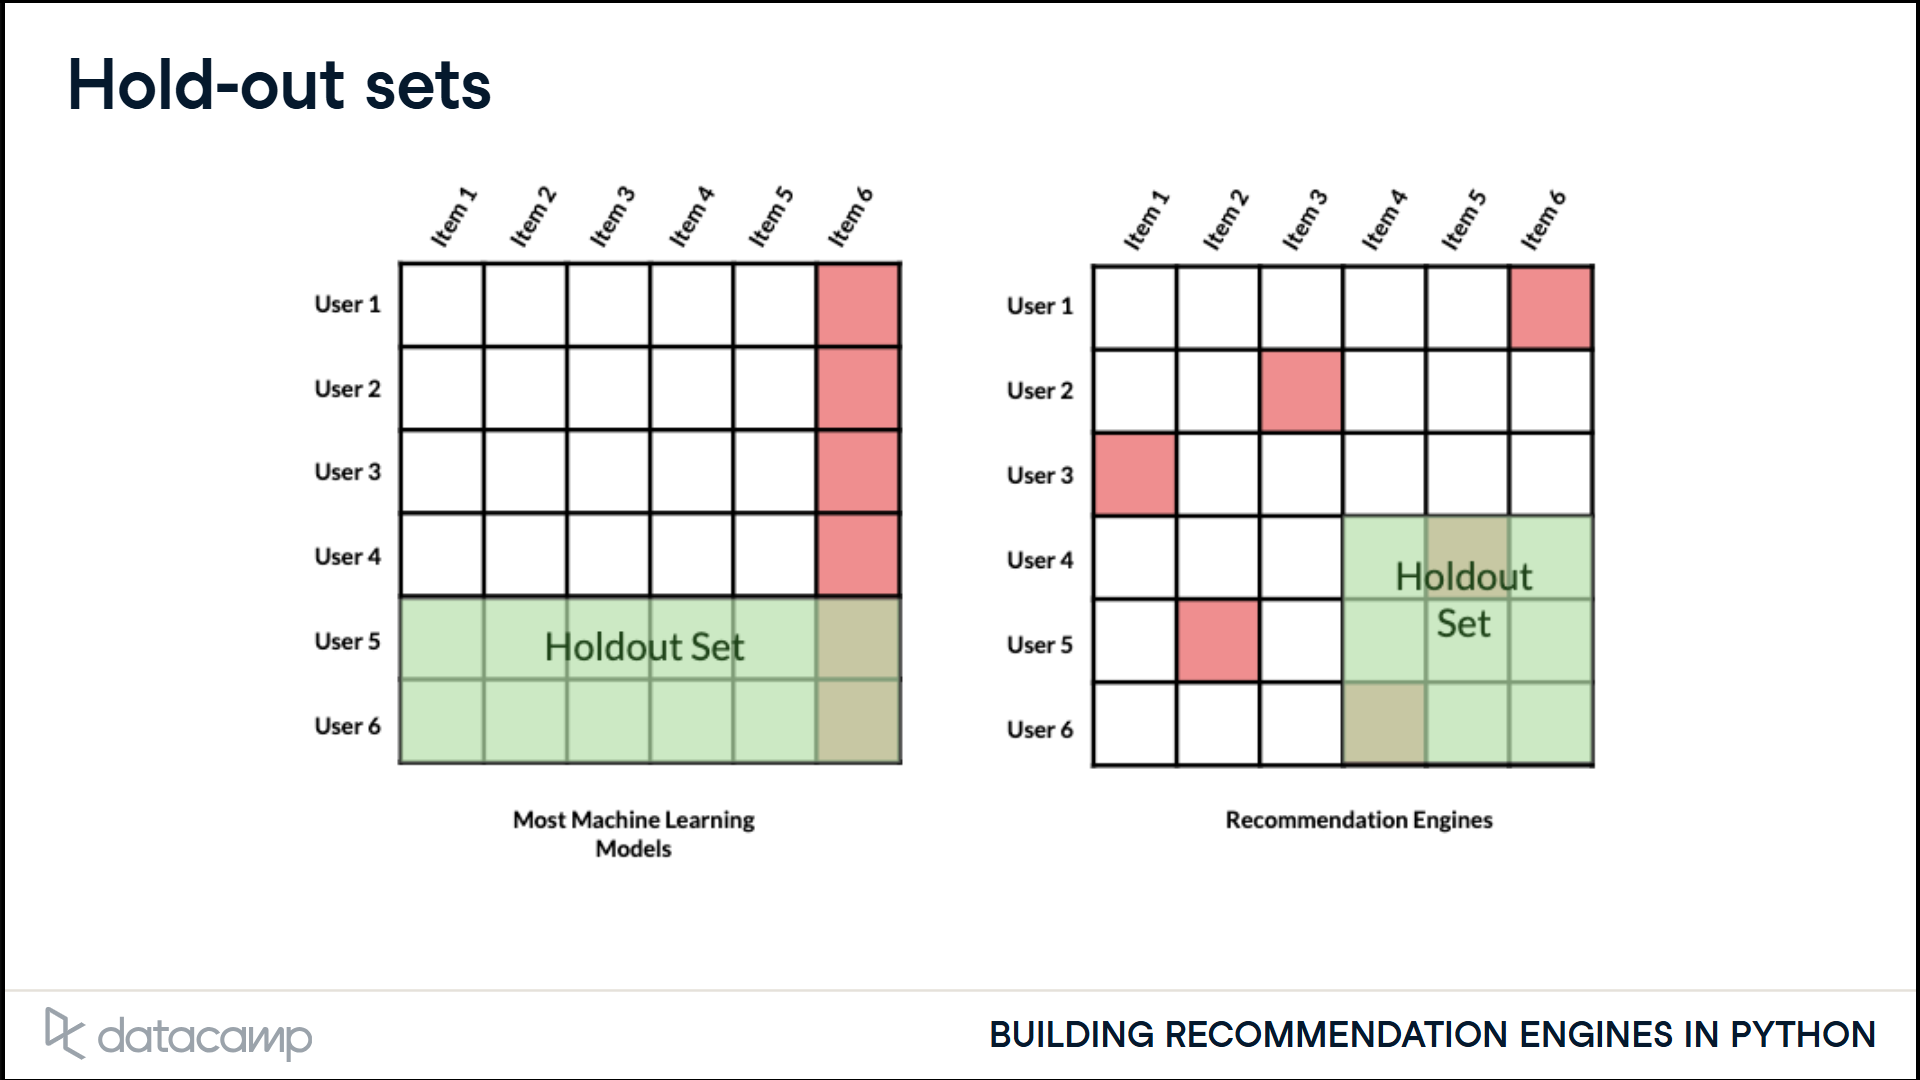

In [47]:
# Define the number of rows and columns to mask (25% of the dataframe).
rows = -int(0.5 * cf_data.shape[0])
cols = -int(0.5 * cf_data.shape[1])

# Create a copy of the dataframe and mask the first 50% of rows and columns.
training_set = cf_data.copy()
training_set.iloc[:rows, :cols] = np.nan

# Drop rows where all values are NaN.
indices = training_set[training_set.isna().all(axis=1)].index
training_set = training_set.drop(indices)

# Extract the dataframe values and create a mask for non-NaN values.
training_set_value = training_set.values
training_mask = ~np.isnan(training_set_value)


The user-item matrix was split to create a training set for collaborative filtering modeling.

1. **Splitting Rows and Columns**
   - The matrix was partitioned by masking **50% of the rows and columns**, setting their values to `NaN` to simulate unseen data for model training.  

2. **Removing Fully NaN Rows**
   - Rows where all values were `NaN` after masking were dropped to ensure valid data for training.

3. **Extracting Values and Mask**:  
   - The processed training set was converted to an array (`training_set_value`) with a corresponding mask (`training_mask`) identifying non-`NaN` values.



In [48]:
# Print the shape of the training set.
print(f'Training set shape: {training_set_value.shape}')

# Print the size of the training set and its percentage.
print(f'Training set size: {training_set_value[training_mask].shape} '
      f'({training_set_value[training_mask].shape[0] / not_nan_count * 100:.2f}%)')

# Display the first 10 non-NaN values in the training set.
print(training_set_value[training_mask][:10])


Training set shape: (4735, 7796)
Training set size: (8853,) (74.64%)
[2. 2. 5. 4. 5. 5. 1. 3. 5. 1.]


Partitioning the matrix allows the model to learn from existing customer-product interactions while withholding part of the data for validation. This approach ensures the robustness of collaborative filtering models in predicting unseen ratings.

- The resulting training set has a shape of **4,735 rows and 7,796 columns**.  
- A total of **8,853 non-NaN values (74.64% of the original non-NaN values)** are available for training.  


In [49]:
# Holdout set excluding rows with all NaN values after the split.
holdout_set = cf_data.copy()
holdout_set = holdout_set.drop(indices)

# Extract values and create a mask for the first 50% of rows and columns.
holdout_set_value = holdout_set.iloc[:rows, :cols].values
holdout_mask = ~np.isnan(holdout_set_value)


A holdout set was created to evaluate the performance of the collaborative filtering model.

1. **Partitioning the Holdout Set**
   - The holdout set was created by retaining only the **masked rows and columns** (50% of the original matrix).  
   - The holdout set excludes rows that were completely `NaN` after the initial split.  

2. **Extracting Values and Mask**:  
   - The holdout set was converted to an array (`holdout_set_value`) with a corresponding mask (`holdout_mask`) identifying non-`NaN` values.

In [50]:
# Print the shape of the holdout set.
print(f'Holdout set shape: {holdout_set_value.shape}')

# Print the size of the holdout set and its percentage.
print(f'Holdout set size: {holdout_set_value[holdout_mask].shape} '
      f'({holdout_set_value[holdout_mask].shape[0] / not_nan_count * 100:.2f}%)')

# Print the first 10 non-NaN values in the holdout set.
print(holdout_set_value[holdout_mask][:10])


Holdout set shape: (2043, 3898)
Holdout set size: (1661,) (14.00%)
[5. 4. 5. 3. 5. 2. 1. 1. 1. 5.]


The holdout set serves as unseen data for evaluating the model's ability to predict customer ratings for products they have not interacted with during training. Using a holdout set ensures an unbiased assessment of the collaborative filtering model's performance.

- The holdout set has a shape of **2,043 rows and 3,898 columns**.  
- A total of **1,661 non-NaN values (14.00% of the original non-NaN values)** are available for evaluation.  

In [51]:
# Calculate average review scores per customer.
avg_review_scores = training_set.mean(axis=1)

# Center the training set by subtracting the average review scores.
training_set_centered = training_set.sub(avg_review_scores, axis=0)

# Replace NaN values with 0 in the centered training set.
training_set_centered = training_set_centered.fillna(0)

# Print the first 10 non-NaN values from the centered training set.
print(training_set_centered.values[training_mask][:10])


[ 0.  0.  0.  0.  0.  2. -2.  0.  0.  0.]


The review scores in the training set were normalized to center each customer’s ratings around zero.

1. **Centering Review Scores**
   - The average review score for each customer was calculated using `training_set.mean(axis=1)`.  
   - The average score was subtracted from each customer’s individual review scores, effectively centering the ratings around zero. This normalization helps account for customer rating bias (e.g., consistently giving higher or lower ratings).  

2. **Filling Missing Values**
   - Missing values (`NaN`) in the centered training set were replaced with zeros. This step ensures compatibility with matrix-based algorithms while retaining the sparse nature of the data.

## **5. Modeling**


### **5.1. Content-Based Filtering**

Content-Based Filtering (CBF) is a recommendation system approach that suggests items to users based on the characteristics of items they have previously interacted with. The system relies on the content (features) of items and the user's historical preferences, without requiring data from other users.

---

#### **How Content-Based Filtering Works**

1. **Item Feature Representation**
   - Each item in the dataset is represented by a set of descriptive attributes (features). These features can be categorical (e.g., genre, category) or numerical (e.g., price, ratings).  
   - In CBF, items are often encoded as vectors in a feature space using techniques such as.
     - **TF-IDF**: Converts textual features into numerical vectors by assigning weights to terms based on their importance.
     - **One-Hot Encoding** or **Embedding**: Used for categorical features.  

2. **User Profile Generation**
   - A **user profile** is built by aggregating the features of items the user has interacted with (e.g., purchased, liked, rated).  
   - For example, the profile may take the average feature values of the items the user interacted with to create a vector representing the user's preferences.  

3. **Similarity Calculation**:  
   - The system calculates the similarity between the user profile and the feature vectors of other items in the dataset. **Cosine Similarity** is a commonly used metric.

4. **Ranking and Recommendation**:  
   - Items are ranked based on their similarity to the user's profile.  
   - The system recommends the top-N items with the highest similarity scores.

---

#### **Advantages of Content-Based Filtering**

1. **Personalization**
   - Recommendations are tailored to each user based on their preferences, leading to highly personalized suggestions.  

2. **No Cold Start for Items**
   - CBF does not depend on user-to-user interactions, so new items with sufficient descriptive features can be recommended immediately.  

3. **Transparency**
   - The system can explain recommendations by pointing to item features that match the user’s preferences (e.g., "Recommended because it matches your interest in health and beauty products").  

---

#### **Challenges of Content-Based Filtering**

1. **Cold Start for Users**
   - The system requires historical data (e.g., purchases or ratings) to generate a user profile. For new users with no interaction history, CBF may struggle.  

2. **Lack of Diversity**
   - The system tends to recommend items similar to what the user has already interacted with, which may lead to a "filter bubble" and limit discovery of diverse content.  

3. **Limited Feature Space**
   - The quality of recommendations depends on the richness and relevance of item features. Poorly described items or sparse features can degrade performance.  

4. **Scalability**
   - For large datasets, computing similarities between all items and users can become computationally expensive.  

---

#### **Applications of Content-Based Filtering**

- **E-commerce**: Suggesting products based on categories, prices, or descriptions.  
- **Streaming Services**: Recommending movies or songs based on genres, ratings, or tags.  
- **Online Education**: Proposing courses based on skill tags or user learning history.  

Content-Based Filtering is a powerful technique when detailed item features are available, and user preferences are well-understood. Its combination with other methods, such as collaborative filtering, can help address its limitations and enhance recommendation quality.

#### **5.1.1. Term Frequency-Inverse Document Frequency**

The implementation prepares text data for CBF by converting combined product features into numerical vectors using **TF-IDF (Term Frequency-Inverse Document Frequency)**. TF-IDF is a text representation technique that assigns weights to terms based on their importance within a document and their rarity across the entire corpus.

1. **Term Frequency (TF)**
   - Measures how frequently a term appears in a document.  
   - **Mathematical Formula**
    $$
    TF(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
    $$

2. **Inverse Document Frequency (IDF)**
   - Weighs terms by their rarity across all documents in the corpus. Rare terms are given higher weights, while common terms receive lower weights.  
   - **Mathematical Formula**
     $$
     IDF(t) = \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing term } t} \right) + 1
     $$

3. **TF-IDF Score**
   - Combines TF and IDF to assign a final weight to each term.  
   - **Mathematical Formula**
     $$
     TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)
     $$

In [52]:
# Instantiate the vectorizer object to the tf variable.
tf = TfidfVectorizer()

# Fit and transform the combined_features column.
vectorized_data = tf.fit_transform(cb_data['combined_features'])

# Look at the features generated.
print(tf.get_feature_names_out()[:10])


['agro_industry_and_commerce' 'air_conditioning' 'art'
 'arts_and_craftmanship' 'audio' 'auto' 'baby' 'bed_bath_table'
 'books_general_interest' 'books_imported']


The TF-IDF approach prioritizes meaningful and unique terms in the product descriptions while minimizing the influence of common terms. This representation is fundamental for calculating product similarities, enabling the recommendation system to identify and recommend similar products effectively.

1. **Vectorization**
   - The `TfidfVectorizer` object was instantiated and applied to the `combined_features` column of `cb_data`.  
   - Each term was assigned a weight based on its TF-IDF score, capturing its importance relative to the product it belongs to and its rarity in the entire dataset.  

2. **Feature Extraction**
   - Distinct terms (features) were extracted from the combined features text.  
   - Products were represented as sparse vectors in a high-dimensional space, where each dimension corresponds to a term's TF-IDF weight.

In [53]:
# Create Dataframe from TF-IDF array.
tfidf_df = pd.DataFrame(
    vectorized_data.toarray(),
    columns=tf.get_feature_names_out()
)

# Assign the product_id to the index.
tfidf_df.index = cb_data['product_id']
sample(tfidf_df)


,short_description,agro_industry_and_commerce,market_place,drinks,cine_photo
product_id,,,,,
e799a2b8707a6a256fa3c040b75d2713,0.000000,0.0,0.0,0.0,0.0
1c6fb703c624b381a20f21f757694866,0.000000,0.0,0.0,0.0,0.0
6d0a373c460a041c86167a92a5d3383e,0.000000,0.0,0.0,0.0,0.0
40678c9096047877fa74a25cc6f0a726,0.000000,0.0,0.0,0.0,0.0
b8a0d73b2a06e7910d9864dccdb0cda2,0.357857,0.0,0.0,0.0,0.0


The TF-IDF matrix was converted into a DataFrame for easier processing.

- The TF-IDF sparse matrix was transformed into a dense DataFrame with terms as columns and TF-IDF scores as values.
- The `product_id` was set as the index to link each row to a specific product.

The DataFrame represents products as numerical vectors based on TF-IDF scores, making it ready for similarity calculations and recommendations.

#### **5.1.2. Cosine Similarity**

Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space. It determines how similar two vectors are, regardless of their magnitude, making it ideal for comparing textual data represented as TF-IDF vectors.  

**Mathematical Formula**

$$
\text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$
Where:  
- $\mathbf{A}$ and $\mathbf{B}$ are the TF-IDF vectors of two products.  
- $\|\mathbf{A}\|$ and $\|\mathbf{B}\|$ are the magnitudes (norms) of the vectors.  
- $\mathbf{A} \cdot \mathbf{B}$ is the dot product of the vectors.  

The similarity ranges from **0** (completely dissimilar) to **1** (identical), making it easy to interpret.  

In [54]:
# Create the array of cosine similarity values.
cosine_similarity_array = cosine_similarity(tfidf_df)

# Wrap the array in a DataFrame.
cosine_similarity_df = pd.DataFrame(
    cosine_similarity_array,
    index=tfidf_df.index,
    columns=tfidf_df.index
)

# Sample cosine similarity matrix.
sample(cosine_similarity_df)


product_id,e799a2b8707a6a256fa3c040b75d2713,1c6fb703c624b381a20f21f757694866,6d0a373c460a041c86167a92a5d3383e,40678c9096047877fa74a25cc6f0a726,b8a0d73b2a06e7910d9864dccdb0cda2
product_id,,,,,
e799a2b8707a6a256fa3c040b75d2713,1.000000,0.231351,1.000000,0.113702,0.131372
1c6fb703c624b381a20f21f757694866,0.231351,1.000000,0.231351,0.271525,0.114323
6d0a373c460a041c86167a92a5d3383e,1.000000,0.231351,1.000000,0.113702,0.131372
40678c9096047877fa74a25cc6f0a726,0.113702,0.271525,0.113702,1.000000,0.000000
b8a0d73b2a06e7910d9864dccdb0cda2,0.131372,0.114323,0.131372,0.000000,1.000000


The cosine similarity matrix was generated to compute the similarity between products based on their TF-IDF vectors.

- The `cosine_similarity` function was applied to the TF-IDF matrix, generating a square matrix where each entry represents the similarity between two products.
- The similarity matrix was converted into a DataFrame, with rows and columns indexed by `product_id`. This allows for intuitive lookup of similarity scores between specific products.

The `cosine_similarity_df` provides pairwise similarity scores between products. These scores enable the recommendation system to identify and rank products most similar to a given product based on their features, forming the foundation of the CBF approach.

#### **5.1.3. Product Recommendation**

In [55]:
# Set a random state for reproducibility.
np.random.seed(42)

# Randomly select a product ID.
product_ids = cosine_similarity_df.index.tolist()
random_product_id = np.random.choice(product_ids)
random_product_id


'4d5bb93bfa70f67cda10b1428f2a252c'

In [56]:
# Find the values for the product '4d5bb93bfa70f67cda10b1428f2a252c'
cosine_similarity_series = cosine_similarity_df.loc[random_product_id]
cosine_similarity_series = cosine_similarity_series.drop(random_product_id)

# Sort these values highest to lowest and keep top 5
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
ordered_similarities = ordered_similarities.head()
ordered_similarities


,4d5bb93bfa70f67cda10b1428f2a252c
product_id,
e65ab426efaf65e083b917d2e9eac80d,0.940602
1589d392201547c9b78a117c0e2191dd,0.881197
44feb28a74abb0f2f303412d60160750,0.881145
652683d85a89f3b134e44989a601bc58,0.881103
1da502ed939a029f4bee6cdc8341b4ac,0.821699


The recommendation system generates product suggestions by identifying the most similar products to a given one based on cosine similarity scores.

- The cosine similarity scores for the product with ID `4d5bb93bfa70f67cda10b1428f2a252c` were retrieved from the `cosine_similarity_df`.
- The similarity scores were sorted in descending order, ranking products from most to least similar to the selected product.
- The top 5 most similar products were selected, representing the closest matches based on their features.

The system outputs a ranked list of the top 5 recommended products, based on their similarity scores to the selected product. These recommendations demonstrate the practical application of CBF for suggesting similar items to customers.

In [57]:
products_df[products_df['product_id'] == random_product_id]

,product_category_name,product_id,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3,price
7270,books_technical,4d5bb93bfa70f67cda10b1428f2a252c,250,1,500,5808,130.8


In [58]:
products_df[products_df['product_id'].isin(ordered_similarities.index)]

,product_category_name,product_id,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3,price
7259,books_technical,44feb28a74abb0f2f303412d60160750,1120,1,500,1350,127.00
7260,books_technical,1589d392201547c9b78a117c0e2191dd,1499,1,450,4356,24.97
7263,books_technical,e65ab426efaf65e083b917d2e9eac80d,445,1,500,6292,147.99
7265,books_technical,1da502ed939a029f4bee6cdc8341b4ac,1345,1,600,1104,29.45
7269,books_technical,652683d85a89f3b134e44989a601bc58,246,1,1100,1764,34.30


The CBF system identified the top 5 most similar products to the product with ID `4d5bb93bfa70f67cda10b1428f2a252c`. All recommended products belong to the same category, **books_technical**, demonstrating the system's ability to effectively identify similar items.  

Features such as **description length**, **photos quantity**, **weight**, **volume**, and **price** are closely aligned with the target product, ensuring the recommendations are relevant. The results showcase the effectiveness of the content-based filtering model in generating tailored product suggestions based on shared attributes.

### **5.2. Collaborative Filtering**

Collaborative Filtering (CF) is a recommendation system technique that suggests items to users based on the preferences and behaviors of other users. It assumes that users who have shown similar preferences in the past are likely to agree on future preferences.

---

#### **Types of Collaborative Filtering**

1. **User-Based Collaborative Filtering**
   - Compares a target user’s preferences with those of other users to find similar users (neighbors).  
   - Recommends items that the similar users (neighbors) have interacted with but the target user has not.  

2. **Item-Based Collaborative Filtering**
   - Compares items based on how users have rated or interacted with them.  
   - Recommends items similar to those the target user has interacted with.  

3. **Matrix Factorization (Model-Based Collaborative Filtering)**
   - Uses mathematical techniques such as **Singular Value Decomposition (SVD)** to decompose the user-item interaction matrix into latent factors.  
   - These latent factors represent hidden patterns in user and item relationships, enabling the system to make recommendations.  

---

#### **How Collaborative Filtering Works**

1. **User-Item Matrix**
   - CF relies on a user-item interaction matrix where rows represent users and columns represent items.  
   - The matrix contains ratings or interactions (e.g., purchases), with missing values indicating no interaction.  

2. **Similarity Measurement**
   - **User-Based CF**: Measures similarity between users using metrics like cosine similarity, Pearson correlation, or Euclidean distance.  
   - **Item-Based CF**: Measures similarity between items based on user interactions.  

3. **Prediction**
   - For user-based or item-based CF, predictions are made by aggregating the interactions of similar users or items.  
   - For model-based CF (e.g., SVD), predictions are made by reconstructing the interaction matrix from latent factors.  

---

#### **Advantages of Collaborative Filtering**

1. **Personalization**
   - Generates highly personalized recommendations by leveraging user behavior patterns.  

2. **No Need for Explicit Features**
   - Does not rely on predefined item attributes or features, as recommendations are based purely on interaction data.  

3. **Scalability with Data**
   - Improves as more users and items are added, revealing deeper patterns in preferences.  

---

#### **Challenges of Collaborative Filtering**

1. **Cold Start Problem**
   - Struggles with recommending items to new users (user cold start) or recommending newly added items (item cold start) due to a lack of interaction data.  

2. **Data Sparsity**
   - User-item matrices are often highly sparse, as users typically interact with only a small subset of items.  

3. **Scalability**
   - User-based or item-based CF can become computationally expensive as the number of users or items grows.  

4. **Over-Specialization**
   - Recommends items similar to those already interacted with, potentially limiting discovery of new or diverse items.  

---

#### **Applications of Collaborative Filtering**

1. **E-Commerce**: Suggesting products based on purchase history or user ratings.  
2. **Streaming Services**: Recommending movies, music, or TV shows based on user preferences.  
3. **Social Media**: Suggesting friends, groups, or content based on shared interests or behaviors.  
4. **Online Education**: Proposing courses or study materials based on interactions and ratings.

CF is a widely used recommendation technique due to its flexibility and ability to leverage implicit patterns in user behavior, making it ideal for scenarios where explicit item features are limited.

#### **5.2.1. Singular Value Decomposition**

Singular Value Decomposition (SVD) is a mathematical technique used to factorize a matrix into three components: two orthogonal matrices and a diagonal matrix of singular values. In collaborative filtering, SVD is applied to the user-item interaction matrix to uncover latent factors that represent hidden relationships between users and items.

**Mathematical Formula**

For a given matrix $R$ of dimensions $m \times n$ (e.g., a user-item matrix):
$$
R = U \Sigma V^T
$$
Where:
- $U$ is an $m \times k$ matrix containing the left singular vectors, representing user latent factors.
- $\Sigma$ is a $k \times k$ diagonal matrix of singular values, representing the importance of each latent factor.
- $V^T$ is a $k \times n$ matrix containing the right singular vectors, representing item latent factors.
- $k$ is the rank of the matrix (or a reduced dimension for approximation).

**Core Concepts**

- **Latent Factor Discovery**

    SVD decomposes the interaction matrix into latent factors for users and items, which capture hidden patterns such as user preferences and item characteristics.

- **Dimensionality Reduction**

    The decomposition allows retaining only the top $k$ singular values and their associated vectors, effectively reducing noise and focusing on the most significant relationships.

- **Reconstruction for Prediction**

    An approximation of the original matrix can be reconstructed using a subset of the singular values.
    $$
    \hat{R} = U_k \Sigma_k V_k^T
    $$
    This reconstruction predicts missing values in the user-item matrix.

SVD is a foundational technique in recommendation systems, enabling robust prediction of missing values and enhancing the ability to personalize recommendations based on hidden user and item characteristics [[4]](https://app.datacamp.com/learn/courses/building-recommendation-engines-in-python).


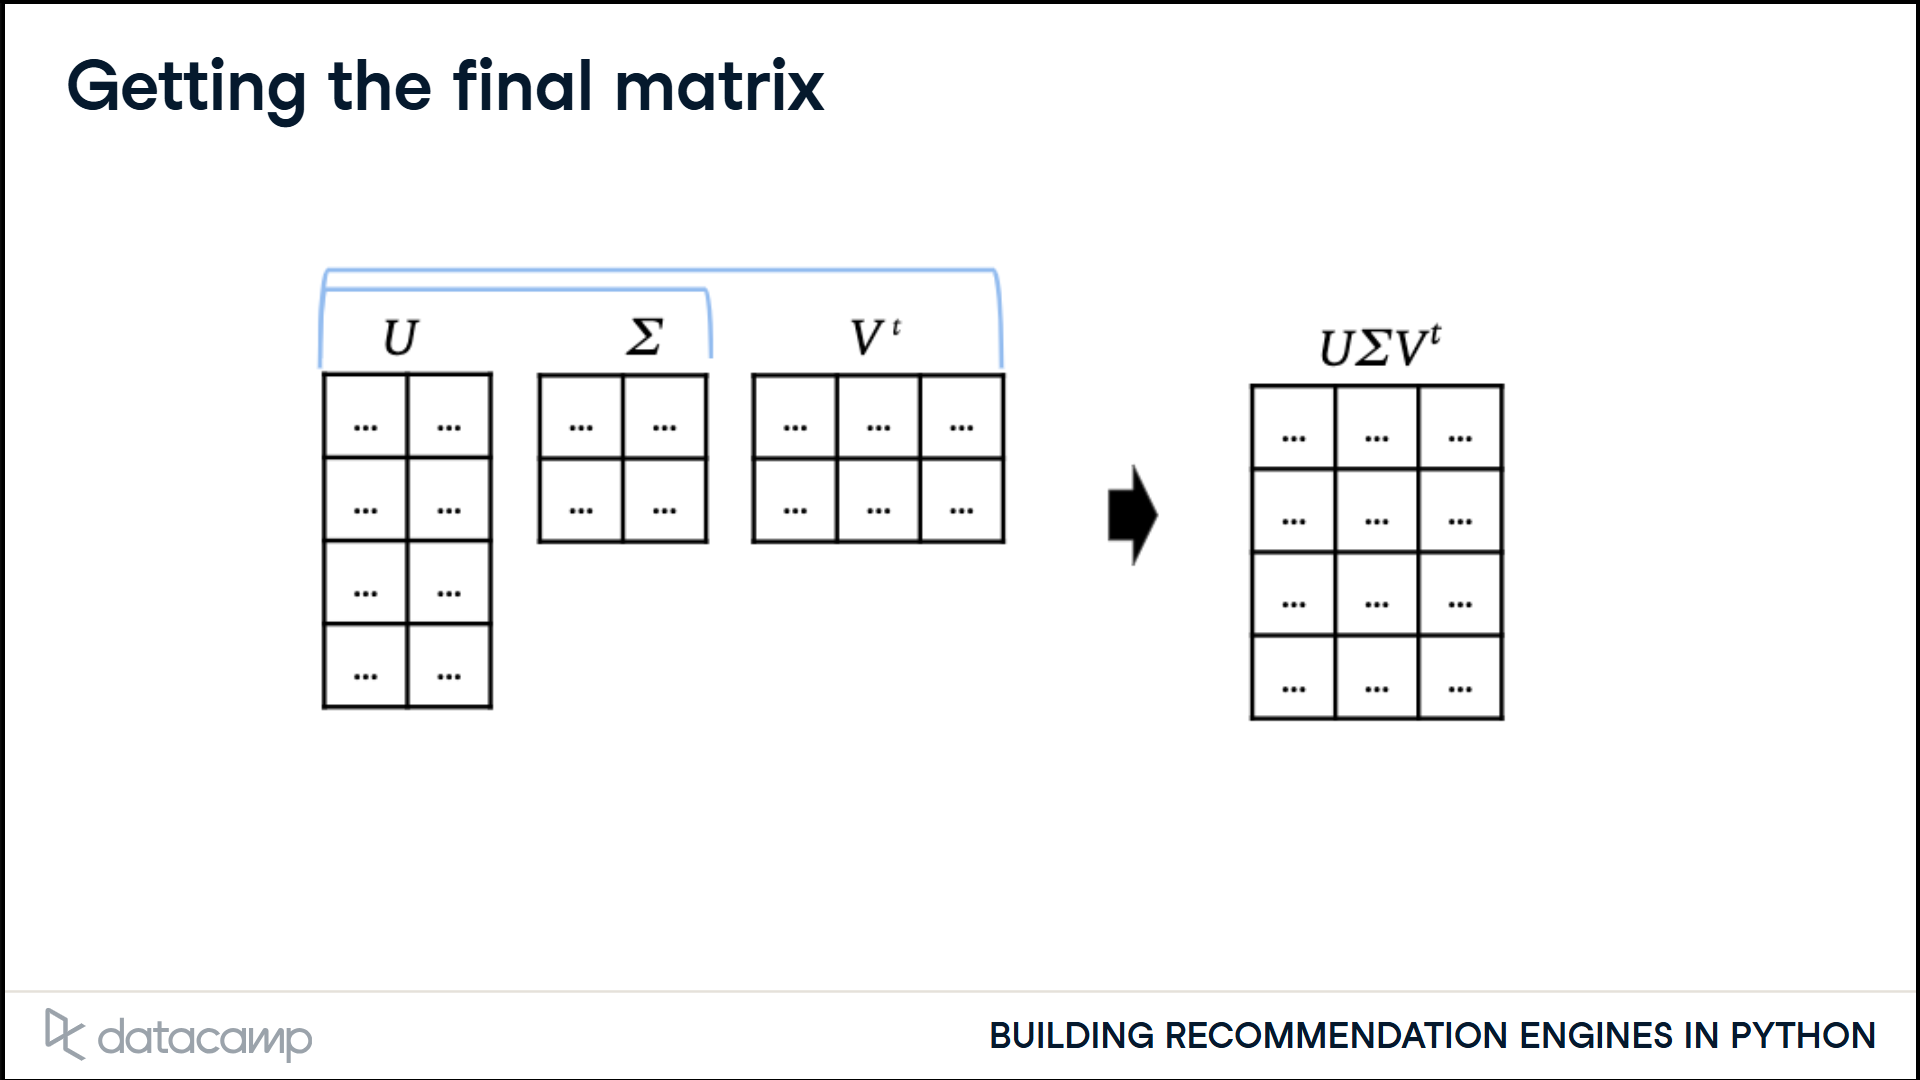

In [59]:
# Decompose the matrix.
U, sigma, Vt = svds(training_set_centered.values)

# Convert sigma into a diagonal matrix.
sigma = np.diag(sigma)
print(sigma)


[[3.46410162 0.         0.         0.         0.         0.        ]
 [0.         3.46410162 0.         0.         0.         0.        ]
 [0.         0.         3.47694722 0.         0.         0.        ]
 [0.         0.         0.         4.08534806 0.         0.        ]
 [0.         0.         0.         0.         4.10283618 0.        ]
 [0.         0.         0.         0.         0.         4.15536656]]


The Singular Value Decomposition (SVD) process was applied to decompose the user-item interaction matrix into three components:

1. **Decomposing the Matrix**
   - The `training_set_centered` matrix was decomposed using the `svds` function, resulting in three matrices.
     - $U$: Contains user latent factors.
     - $\Sigma$: A diagonal matrix of singular values representing the importance of each latent factor.
     - $V^T$: Contains item latent factors.

2. **Converting $\Sigma$ into a Diagonal Matrix**
   - The singular values extracted by `svds` were converted into a diagonal matrix using `np.diag`, making them ready for reconstruction or dimensionality reduction.

The diagonal matrix $\Sigma$ indicates the significance of the corresponding latent factors in explaining variations in the data. Larger singular values (e.g., 4.155) signify more influential latent factors, which are critical for reconstructing the user-item matrix and predicting missing interactions.
This decomposition lays the foundation for generating recommendations by reconstructing the interaction matrix with the dominant latent factors.

#### **5.2.2. Interaction Matrix Reconstruction**

In [60]:
# Dot product of U and sigma.
U_sigma = np.dot(U, sigma)

# Dot product of result and Vt.
U_sigma_Vt = np.dot(U_sigma, Vt)

# Add back on the row means contained in avg_ratings.
predicted_review_scores = U_sigma_Vt + avg_review_scores.values.reshape(-1, 1)

# Create DataFrame of the recalculated_review_scores.
predictions_df = pd.DataFrame(
    predicted_review_scores,
    index=training_set.index,
    columns=training_set.columns
)

# Sample interaction matrix.
sample(predictions_df)


product_id,609b1b50202d276e56b2468006fa82aa,b57469faf40b556e16b9a49308953700,5c973b4202aac5c372a483e712306f4f,21fb5057dd6a737df6851a7ab7a130da,0449db5eede617c5fd413071d582f038
customer_unique_id,,,,,
93affc403753dca0735740ee2458860a,1.0,1.0,1.0,1.0,1.0
1610d8d6bc3013aaf6e558ec18cc8350,5.0,5.0,5.0,5.0,5.0
5a85f706b2059c3cd55287e105d8d5ea,3.5,3.5,3.5,3.5,3.5
fcda364be74555da695b4afe5166c2b1,4.0,4.0,4.0,4.0,4.0
d92462d83762d5e5c112bccc344119e6,5.0,5.0,5.0,5.0,5.0


The interaction matrix was reconstructed using the components obtained from Singular Value Decomposition (SVD). This process predicts the missing values in the user-item interaction matrix, enabling recommendations for unseen user-item interactions.

1. **Matrix Reconstruction**
   - The dot product of $U$ (user latent factors) and $\Sigma$ (singular values) was calculated to obtain $U \Sigma$.
   - The result was further multiplied with $V^T$ (item latent factors), reconstructing the interaction matrix in its centered form $( U \Sigma V^T)$.

2. **Adding Row Means**
   - The row-wise mean ratings (`avg_ratings`) were added back to the reconstructed matrix to restore the original scale of review scores. This adjustment ensures that the predicted values align with the actual rating scale.

3. **Saving Reconstructed Matrix**
   - The final reconstructed matrix, containing predicted review scores for all user-item pairs, was converted into a DataFrame (`predictions_df`) with users as rows and items as columns.

The `predictions_df` now contains predicted review scores for all users and items, filling in the missing values in the original matrix. These predictions form the basis for recommending items to users by identifying those with the highest predicted scores. This reconstructed matrix captures the latent relationships between users and items, enabling the system to predict user preferences for items they have not interacted with.

#### **5.2.3. Product Recommendation**

In [61]:
# Set random state for reproducibility
np.random.seed(42)

# Randomly select one customer ID
customer_unique_ids = orders_df[
    'customer_unique_id'
][orders_df['review_score'] == 5].unique().tolist()
random_customer_id = np.random.choice(customer_unique_ids)
random_customer_id


'175b8225bdd99e95a64e07a6c06e8746'

In [62]:
# Get sorted predictions for a random customer.
recommendations = predictions_df.loc[
    random_customer_id
].sort_values(ascending=False)

# Select the top recommendations.
recommendations = recommendations.head()

# Display the top recommendations.
recommendations


,175b8225bdd99e95a64e07a6c06e8746
product_id,
0011c512eb256aa0dbbb544d8dffcf6e,5.0
aacee6f1f7be193e891a8cca7a3a849a,5.0
abe171a94bee936786955f928bd764ab,5.0
abda62f854cffdc94184e6bccadc2286,5.0
abd7f7a1bd327a8f1f363abfc0f87391,5.0


The CF model generates product recommendations for a specific customer based on predicted review scores from the reconstructed interaction matrix.

- A customer ID was randomly selected from those who have provided a review score of 5, ensuring that the recommendations target a highly engaged user.
- Predicted review scores for all products were retrieved from the `predictions_df` for the selected customer.
- The predicted review scores were sorted in descending order, ranking products from most to least preferred.
- The top 5 products with the highest predicted review scores were selected as recommendations.

CF model’s predict user preferences based on latent factors derived from the interaction matrix. The selected items are highly tailored to the customer’s inferred interests, enabling a personalized recommendation experience.  

In [63]:
# Get a list of products bought by the random customer.
list_of_products_bought = orders_df[
    orders_df['customer_unique_id'] == random_customer_id
]['product_id'].tolist()

# Filter and display product details for the products bought.
products_df[products_df['product_id'].isin(list_of_products_bought)]


,product_category_name,product_id,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3,price
1824,bed_bath_table,8d944f9367ba7f153e0ab5b6dc7d063b,237,1,1500,13690,114.9
2208,bed_bath_table,151d7733b44e0c7b292d7e2efb5424a2,305,1,3950,19200,279.9


In [64]:
products_df[products_df['product_id'].isin(recommendations.index)]

,product_category_name,product_id,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3,price
795,auto,0011c512eb256aa0dbbb544d8dffcf6e,177,1,100,3840,52.00
1284,bed_bath_table,abe171a94bee936786955f928bd764ab,553,1,1300,7875,81.80
4487,housewares,abda62f854cffdc94184e6bccadc2286,810,4,800,16038,68.00
5990,fashion_bags_accessories,aacee6f1f7be193e891a8cca7a3a849a,726,6,100,1584,79.90
6217,fashion_bags_accessories,abd7f7a1bd327a8f1f363abfc0f87391,367,1,100,612,39.99


The CF system identified the top 5 recommended products for the customer with ID `175b8225bdd99e95a64e07a6c06e8746`. The recommendations span diverse categories, including **auto**, **housewares**, **fashion_bags_accessories**, and **bed_bath_table**, showcasing the system's ability to balance relevance and exploration.

Features such as **description length**, **photos quantity**, **weight**, **volume**, and **price** vary across the recommended products, introducing diversity while partially aligning with the customer’s previous preferences in the **bed_bath_table** category. The results demonstrate the effectiveness of the CF model in generating personalized recommendations that combine familiar and novel options.

## **6. Evaluation**


### **6.1. Content-Based Filtering**

#### **6.1.1. Customer Profile Recommendation**

The effectiveness of the CBF system was evaluated by analyzing the alignment of recommended products with the customer’s preferences, using both qualitative insights and quantitative metrics.

In [65]:
# Set a random state for reproducibility
np.random.seed(42)

# Randomly select a customer unique ID
customer_unique_ids = orders_df['customer_unique_id'].unique().tolist()
random_customer_id = np.random.choice(customer_unique_ids)
random_customer_id


'048df8b25dc48e1554eccde119d6cecd'

In [66]:
# Get a list of products bought by the random customer.
list_of_products_bought = orders_df[
    orders_df['customer_unique_id'] == random_customer_id
]['product_id'].tolist()

# Reindex TF-IDF dataframe to include only products bought by the customer.
products_bought_df = tfidf_df.reindex(list_of_products_bought)

# Calculate the customer's profile by averaging TF-IDF scores of bought products.
customer_prof = products_bought_df.mean()

# Display the top features in the customer's profile with positive scores.
customer_prof[customer_prof > 0].sort_values(ascending=False).head()


,0
baby,0.696268
many_photos,0.352389
medium_volume,0.317158
long_description,0.316169
light_weight,0.300955


A customer profile was generated based on the products they have purchased. The profile represents the average attributes of the items, highlighting the customer's preferences.  

- A subset of the TF-IDF DataFrame (`tfidf_df`) was created, containing only the rows corresponding to the products purchased by the customer.  
- The average scores of the features for the purchased products were calculated, forming the customer's profile.  
- Features with the highest average scores indicate the customer's most significant preferences.  

The customer's profile reveals preferences for the following top features.
- **baby**: Indicates interest in baby-related products.  
- **many_photos**: Suggests a preference for products with more images.  
- **medium_volume**: Highlights a tendency toward medium-sized products.  
- **long_description**: Shows a preference for products with detailed descriptions.  
- **light_weight**: Indicates favorability toward lighter products.  

In [67]:
# Find subset of tfidf_df that does not include products in list_of_products_bought
tfidf_subset_df = tfidf_df.drop(list_of_products_bought, axis=0)

# Calculate the cosine_similarity and wrap it in a DataFrame
similarity_array = cosine_similarity(
    customer_prof.values.reshape(1, -1),
    tfidf_subset_df
)
similarity_df = pd.DataFrame(
    similarity_array.T,
    index=tfidf_subset_df.index,
    columns=["similarity_score"]
)

# Sort the values from high to low by the values in the similarity_score
sorted_similarity_df = similarity_df.sort_values(
    "similarity_score",
    ascending=False
)

# Inspect the most similar to the customer preferences
sorted_similarity_df = sorted_similarity_df.head()
sorted_similarity_df


,similarity_score
product_id,
103aed057190376889bc9e796affa24e,0.974703
c8078bb7927143cdb008e3563230ca61,0.923546
3b213ba02fcd0799a85c9c3580a3033d,0.877390
14ad6805c263d8d758d648f46a06570e,0.877390
cac9e5692471a0700418aa3400b9b2b1,0.877389


The recommendation system generates product suggestions for a customer by identifying items most similar to their profile based on cosine similarity.  

- The `tfidf_df` was filtered to exclude products the customer has already purchased (`list_of_products_bought`). This ensures recommendations include only new products.  
- The customer's profile vector was compared with the remaining products in the `tfidf_subset_df` using cosine similarity, generating a similarity score for each product.  
- The resulting similarity scores were wrapped in `similarity_df` for easier analysis.  
- The products were sorted in descending order by their similarity scores, ranking the most relevant items at the top.  

The top 5 product recommendations for the customer are identified based on their similarity to the customer’s preferences. These recommendations are tailored to the customer's profile, suggesting items most aligned with their past purchasing behavior and interests.

In [68]:
products_df[products_df['product_id'].isin(list_of_products_bought)]

,product_category_name,product_id,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3,price
5273,baby,ac946196783ec18b207ead8a00d3f5c4,740,3,167,4725,54.9
5280,baby,b865aecbf934fe78d172e5a0f7a73ec0,1344,3,400,5120,149.9


In [69]:
products_df[products_df['product_id'].isin(sorted_similarity_df.index)]

,product_category_name,product_id,product_description_lenght,product_photos_qty,product_weight_g,volume_cm3,price
5240,baby,103aed057190376889bc9e796affa24e,1355,4,332,3840,149.33
5259,baby,3b213ba02fcd0799a85c9c3580a3033d,1640,1,350,8000,54.90
5260,baby,c8078bb7927143cdb008e3563230ca61,1978,4,250,7865,19.90
5269,baby,14ad6805c263d8d758d648f46a06570e,782,1,350,4536,60.66
5286,baby,cac9e5692471a0700418aa3400b9b2b1,2440,1,375,8120,119.93


The recommendation system generates product suggestions for a customer based on their profile. Below are insights into the purchased and recommended products.

**Customer's Purchased Products**

The customer has previously purchased two products in the **baby** category.
- Products with moderate description lengths (**740** and **1344 characters**).
- Consistent photo count (**3 photos** for both products).
- Lightweight items (**167 g** and **400 g**) with moderate volumes.

**Recommended Products**

The system recommended five new products in the **baby** category, which align with the customer’s preferences.
- Products with detailed descriptions (ranging from **782 to 2440 characters**).
- Varied photo counts (**1 to 4 photos**), including higher photo counts than previously purchased items.
- Lightweight items (weights between **250 g and 375 g**) and moderate to large volumes.

The recommended products closely match the customer’s preference for the **baby** category, lightweight products, and moderate-to-detailed descriptions. The recommendation system effectively suggests items that complement the customer’s profile while introducing new options, such as varying photo counts and slightly different volumes.

#### **6.1.2. Quantitative Evaluation Metrics**

1. **Precision@5**

   Measures the proportion of top-5 recommended products that match the customer's preferences.  

   **Calculation**

   Out of the 5 recommendations, all products matched the customer’s preference for the **baby** category.
   $$
   \text{Precision@5} = \frac{\text{Relevant Recommendations}}{\text{Total Recommendations}} = \frac{5}{5} = 1.0 \, (100\%)
   $$  

2. **Diversity Score**

   Assesses variation in product features among recommendations.  
   - The recommendations showed variation in **description lengths** (782–2440 characters), **photo counts** (1–4 photos), and **volume** (4536–8120 cm³).  
   - The diversity in features ensures the recommendations cater to the customer’s general preferences while introducing variety.  

3. **Hit Rate**

   Evaluates whether at least one recommended product matches the customer’s true preferences.  
   - All 5 recommendations matched the customer’s interest in the **baby** category, yielding a **Hit Rate = 1.0 (100%)**.  

4. **Mean Reciprocal Rank (MRR)**

   Determines the rank of the first relevant product in the recommendation list. Since all recommendations are relevant.
   $$
   \text{MRR} = \frac{1}{\text{Rank of First Relevant Recommendation}} = 1.0
   $$  


### **6.2. Collaborative Filtering**

#### **6.2.1. Root Mean Squared Error**

Root Mean Squared Error (RMSE) is a standard metric for evaluating the accuracy of predicted values in regression-based systems, including collaborative filtering using SVD. RMSE provides a measure of the average difference between predicted ratings (from the reconstructed user-item matrix) and actual ratings, making it an essential evaluation method for recommendation systems.

**Mathematical Formula**

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$
Where:
- $y_i$: Actual user rating for an item.
- $\hat{y}_i$: Predicted rating for the same item (from the reconstructed matrix).
- $n$: Total number of predicted ratings being evaluated.

RMSE outputs a single value that quantifies the prediction error, expressed in the same unit as the ratings (e.g., on a scale of 1 to 5).




In [70]:
# Extract prediction values for the first 50% of rows and columns.
predictions_value = predictions_df.iloc[:rows, :cols].values

# Print the first 20 prediction values that match the holdout mask.
print(predictions_value[holdout_mask][:20])

# Print the first 20 actual values from the holdout set that match the holdout mask.
print(holdout_set_value[holdout_mask][:20])


[5. 4. 5. 3. 5. 2. 1. 1. 1. 5. 1. 1. 5. 3. 4. 4. 5. 4. 5. 5.]
[5. 4. 5. 3. 5. 2. 1. 1. 1. 5. 1. 1. 5. 3. 3. 5. 4. 4. 5. 5.]


The comparison between predicted and actual review scores highlights the collaborative filtering model’s accuracy in approximating user preferences. Predicted ratings from the reconstructed interaction matrix closely align with actual ratings from the holdout set, with minimal deviations observed. The analysis demonstrates strong performance and forms the basis for calculating evaluation metrics such as RMSE, which quantifies the model's prediction error.

In [71]:
# Calculate the RMSE between actual values and predictions in the holdout set.
rmse = mean_squared_error(
    holdout_set_value[holdout_mask],
    predictions_value[holdout_mask],
    squared=False
).round(2)

# Print the RMSE value.
print(f'RMSE of SVD Predictions: {rmse}')


RMSE of SVD Predictions: 0.86


The performance of the collaborative filtering model using SVD was evaluated by calculating the Root Mean Squared Error (RMSE) between predicted and actual review scores. The RMSE value of **0.86** indicates the average deviation of the predicted ratings from the actual ratings. This low RMSE demonstrates that the model effectively captures user preferences and provides accurate predictions, confirming its reliability for generating recommendations.

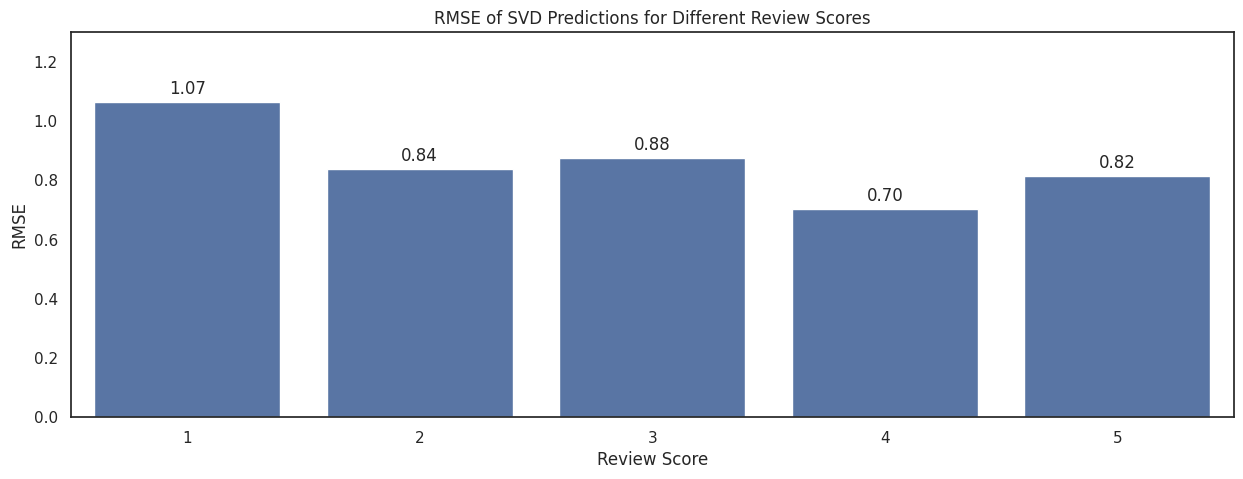

In [72]:
# Calculate RMSE for each review score from 1 to 5.
rmse_per_rating = []
for rating in range(1, 6):
    mask = (holdout_set_value[holdout_mask] == rating)
    if sum(mask) > 0:
        rmse = mean_squared_error(
            holdout_set_value[holdout_mask][mask],
            predictions_value[holdout_mask][mask],
            squared=False
        )
        rmse_per_rating.append((rating, rmse))

# Create a DataFrame for RMSE per rating.
df_rmse = pd.DataFrame(rmse_per_rating, columns=['Rating', 'RMSE'])

# Plot RMSE for different review scores.
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Rating', y='RMSE', data=df_rmse)
plt.title('RMSE of SVD Predictions for Different Review Scores')
plt.xlabel('Review Score')
plt.ylabel('RMSE')

# Annotate the bar plot with RMSE values.
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points'
    )

# Adjust y-axis limits and show the plot.
plt.ylim(0, 1.3)
plt.show()


The RMSE analysis across review scores reveals that the collaborative filtering model performs best for higher ratings. The RMSE for **review score 4** is the lowest at **0.70**, followed by **0.82** for score 5. Prediction errors are higher for lower scores, with RMSE reaching **1.07** for score 1. This indicates the model predicts higher ratings more accurately while struggling with lower ratings.

### **6.3. Insight**

Recommendation system successfully developed using **content-based filtering** and **collaborative filtering** approaches, delivering personalized product suggestions to improve customer satisfaction and merchant success on the Olist platform.  

1. **Content-Based Filtering Results**:  
   - Products were recommended based on shared attributes such as **category**, **description length**, **number of photos**, **weight**, **volume**, and **price**.  
   - The system demonstrated strong relevance by recommending products closely aligned with the user’s purchasing history while maintaining diversity in features to enhance product discovery.  

2. **Collaborative Filtering Results**:  
   - Collaborative filtering using **Singular Value Decomposition (SVD)** predicted user review scores for products, enabling recommendations based on latent patterns in user behavior.  
   - The model achieved an overall **RMSE of 0.86**, indicating accurate prediction performance. Analysis across review scores revealed the model performed best for higher ratings, with the lowest RMSE of **0.70** for review score 4.  

The system effectively balances relevance and diversity, ensuring that users receive accurate, tailored recommendations while discovering new products. Improved recommendation accuracy supports Olist’s goals of increasing customer engagement, boosting sales, and empowering small businesses across its platform.

## **7. References**

[1] Stalidis, G., Karaveli, I., Diamantaras, K., Delianidi, M., Christantonis, K., Tektonidis, D., Katsalis, A., & Salampasis, M. (2023). Recommendation Systems for e-Shopping: Review of Techniques for Retail and Sustainable Marketing. Sustainability, 15(23), 16151. https://doi.org/10.3390/su152316151

[2] Abdul Hussien, F. T., Rahma, A. M. S., & Abdulwahab, H. B. (2021). An E-Commerce Recommendation System Based on Dynamic Analysis of Customer Behavior. Sustainability, 13(19), 10786. https://doi.org/10.3390/su131910786

[3] kaggle. 2018. https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

[4] datacamp. 20204. https://app.datacamp.com/learn/courses/building-recommendation-engines-in-python

